## Overall Approach:
- The given dataset has values from August 1995 to 28th February 2021, we need to forecast for 19 days ahead i.e. swap curve for 19th March 2021.
- Methods used for forecasting are Vector Autoregression and Autoencoders.


### Importing necessary libraries

In [149]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
plt.rcParams["figure.figsize"] = (15,7)
from scipy.stats import shapiro
from statsmodels.tsa.api import VAR
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import plotly
from chart_studio import plotly as py
import plotly.graph_objs as go
import chart_studio
chart_studio.tools.set_credentials_file(username='mohita24',api_key='Gl9VXrB19507Nlicdlwe')
# Authenticate with your account
#plotly.tools.set_credentials_file(username='mohita24',                                              
#                                  api_key='Gl9VXrB19507Nlicdlwe')
# Offline mode
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)






### Importing the data

In [150]:
df=pd.read_csv("CADCurve dep.csv")
x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in df["Date"]]
df=df.iloc[:,1:]
df.index=x
df.head()

1M       2M        3M       6M        9M        1Y  \
1995-07-14  0.065547  0.06447  0.063373  0.06397  0.064241  0.064587   
1995-07-15  0.065547  0.06447  0.063373  0.06397  0.064241  0.064587   
1995-07-16  0.065547  0.06447  0.063373  0.06397  0.064241  0.064587   
1995-07-17  0.065547  0.06447  0.063373  0.06397  0.064241  0.064587   
1995-07-18  0.065547  0.06447  0.063373  0.06397  0.064241  0.064587   

                  2Y        3Y        4Y        5Y        6Y        7Y  \
1995-07-14  0.067764  0.069852  0.072227  0.074802  0.076541  0.078377   
1995-07-15  0.067764  0.069852  0.072227  0.074802  0.076541  0.078377   
1995-07-16  0.067764  0.069852  0.072227  0.074802  0.076541  0.078377   
1995-07-17  0.067764  0.069852  0.072227  0.074802  0.076541  0.078377   
1995-07-18  0.067764  0.069852  0.072227  0.074802  0.076541  0.078377   

                  8Y        9Y       10Y  
1995-07-14  0.079875  0.081453  0.083113  
1995-07-15  0.079875  0.081453  0.083113  
1995-07-16  0.079875  0.081453  0.083113  
1995-07-17  0.079875  0.081453  0.083113  
1995-07-18  0.079875  0.081453  0.083113

## Exploratory Data Analysis
### Checking for missing values

There are no missing values in our data

In [3]:
df.isna().any()

1M     False
2M     False
3M     False
6M     False
9M     False
1Y     False
2Y     False
3Y     False
4Y     False
5Y     False
6Y     False
7Y     False
8Y     False
9Y     False
10Y    False
dtype: bool

### Data Description

In [259]:
df.describe()

1M           2M           3M           6M           9M  \
count  9362.000000  9362.000000  9362.000000  9362.000000  9362.000000   
mean      0.025948     0.026146     0.026383     0.026947     0.027473   
std       0.016633     0.016594     0.016537     0.016423     0.016482   
min       0.003783     0.004050     0.004279     0.003937     0.003964   
25%       0.012010     0.012458     0.012740     0.012870     0.012961   
50%       0.021725     0.021799     0.022157     0.022981     0.024042   
75%       0.042293     0.042099     0.041979     0.042596     0.042426   
max       0.072257     0.072728     0.072506     0.072638     0.072282   

                1Y           2Y           3Y           4Y           5Y  \
count  9362.000000  9362.000000  9362.000000  9362.000000  9362.000000   
mean      0.027583     0.029847     0.031964     0.033711     0.035233   
std       0.016987     0.017577     0.017837     0.018025     0.018206   
min       0.004248     0.004645     0.005664     0.006274     0.006733   
25%       0.012785     0.013903     0.015860     0.017538     0.018802   
50%       0.024799     0.029353     0.032273     0.034436     0.036178   
75%       0.042693     0.044686     0.047434     0.049505     0.050393   
max       0.071924     0.086129     0.090377     0.093208     0.096282   

                6Y           7Y           8Y           9Y          10Y  
count  9362.000000  9362.000000  9362.000000  9362.000000  9362.000000  
mean      0.036499     0.037747     0.038790     0.039814     0.040832  
std       0.018215     0.018283     0.018221     0.018210     0.018251  
min       0.007292     0.007853     0.008284     0.008701     0.009123  
25%       0.019748     0.020937     0.022094     0.023300     0.024315  
50%       0.037738     0.038966     0.040142     0.041134     0.042068  
75%       0.051501     0.052805     0.053757     0.054565     0.055415  
max       0.097843     0.099548     0.101402     0.103391     0.105535

### Boxplot and Histogram: To identify outliers and the distribution.
We observe few outliers for 8Y, 9Y and 10 Y.
Also, from the box plot we can see that the distribution is not gaussian.

array([[<AxesSubplot:title={'center':'10Y'}>,
        <AxesSubplot:title={'center':'1M'}>,
        <AxesSubplot:title={'center':'1Y'}>,
        <AxesSubplot:title={'center':'2M'}>],
       [<AxesSubplot:title={'center':'2Y'}>,
        <AxesSubplot:title={'center':'3M'}>,
        <AxesSubplot:title={'center':'3Y'}>,
        <AxesSubplot:title={'center':'4Y'}>],
       [<AxesSubplot:title={'center':'5Y'}>,
        <AxesSubplot:title={'center':'6M'}>,
        <AxesSubplot:title={'center':'6Y'}>,
        <AxesSubplot:title={'center':'7Y'}>],
       [<AxesSubplot:title={'center':'8Y'}>,
        <AxesSubplot:title={'center':'9M'}>,
        <AxesSubplot:title={'center':'9Y'}>, <AxesSubplot:>]],
      dtype=object)

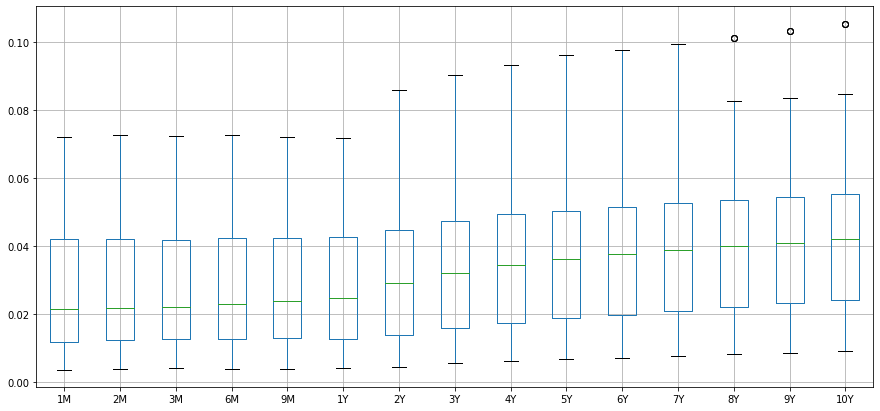

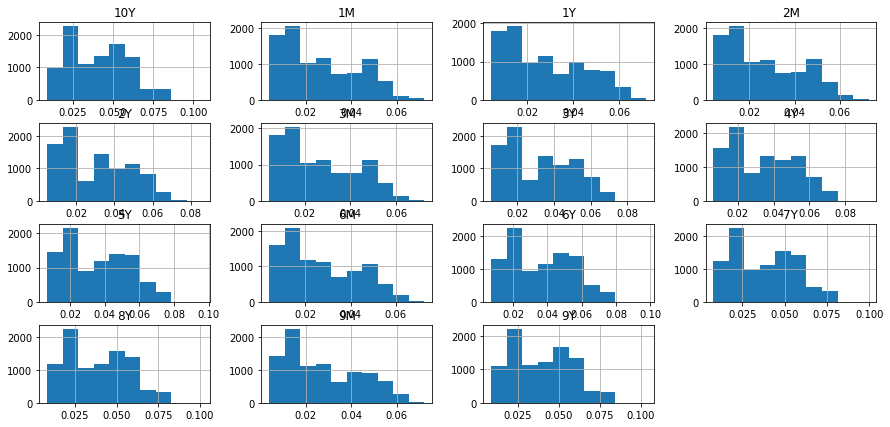

In [263]:
df.boxplot()
df.hist()

## Visualizing the Multivariate time series

- A general downward trend is observed.
- No specific seasonality is observed.

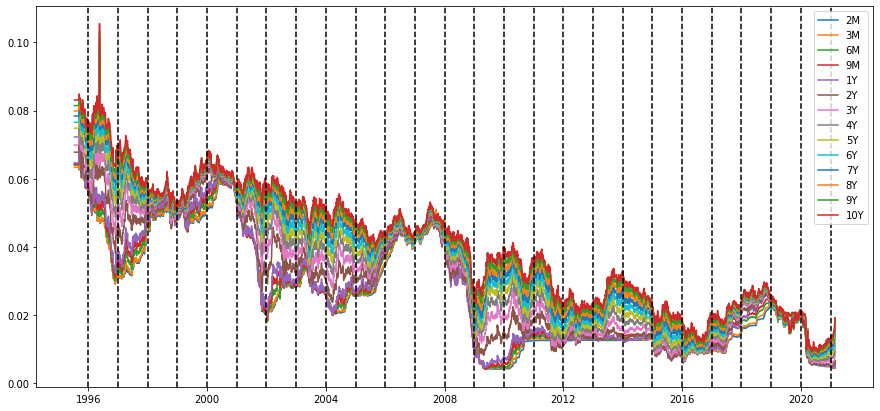

In [264]:
for i in df.columns[1:]:
    plt.plot(x,df[i],label=i)
    plt.legend()
xcoords = ['1996-01-01','1997-01-01', '1998-01-01', '1999-01-01', '2000-01-01','2001-01-01',
    '2002-01-01', '2003-01-01','2004-01-01', '2005-01-01', '2006-01-01', '2007-01-01','2008-01-01','2009-01-01','2010-01-01', '2011-01-01',
           '2012-01-01', '2013-01-01',
           '2014-01-01','2015-01-01', '2016-01-01','2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01',
          '2021-01-01']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

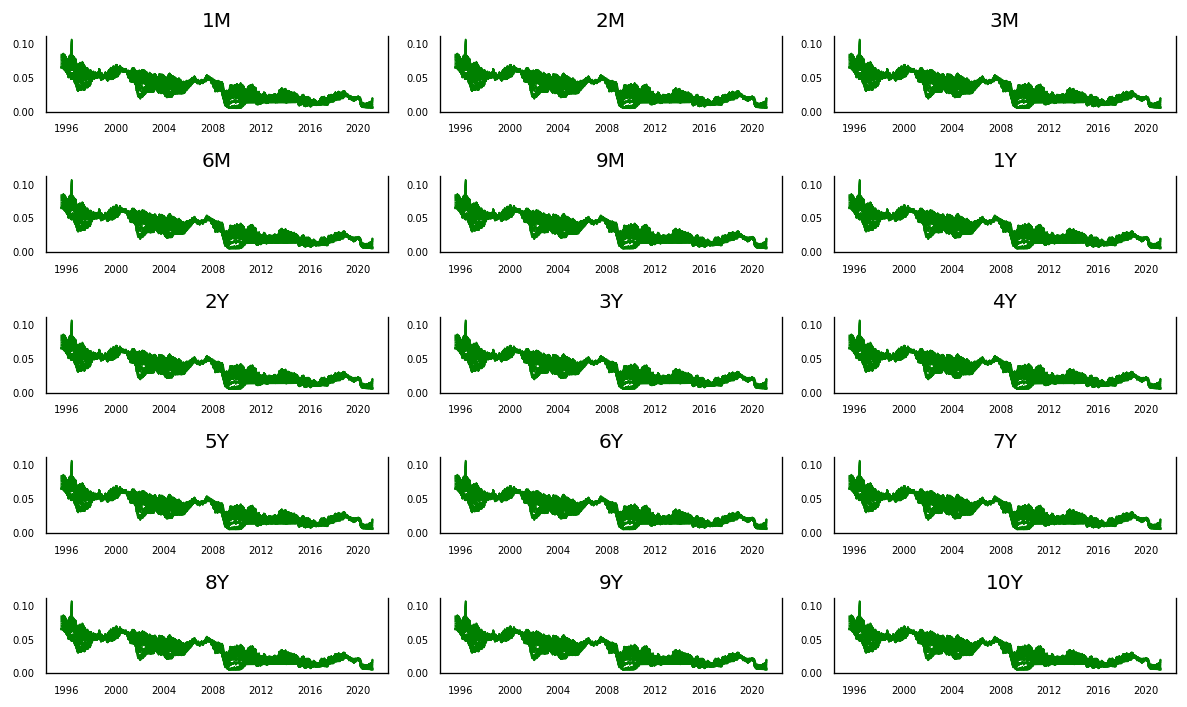

In [119]:
fig, axes = plt.subplots(nrows=5, ncols=3, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(df, color='g', linewidth=1)
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout();

## Checking for Gaussian distribution, kurtosis and skewness

In [4]:
for i in df.columns:
    print("For: ",i)
    stat,p = stats.normaltest(df[i])
    print("Statistics = %.3f, p=%.3f" % (stat,p))
    if p> 0.05:
        print('Data looks Gaussian (fail to reject null hypothesis)')
    else:
        print('Data looks non-Gaussian (reject null hypothesis')

For:  1M
Statistics = 2214.137, p=0.000
Data looks non-Gaussian (reject null hypothesis
For:  2M
Statistics = 2277.208, p=0.000
Data looks non-Gaussian (reject null hypothesis
For:  3M
Statistics = 2333.441, p=0.000
Data looks non-Gaussian (reject null hypothesis
For:  6M
Statistics = 2223.185, p=0.000
Data looks non-Gaussian (reject null hypothesis
For:  9M
Statistics = 2420.287, p=0.000
Data looks non-Gaussian (reject null hypothesis
For:  1Y
Statistics = 3206.231, p=0.000
Data looks non-Gaussian (reject null hypothesis
For:  2Y
Statistics = 4097.573, p=0.000
Data looks non-Gaussian (reject null hypothesis
For:  3Y
Statistics = 4499.093, p=0.000
Data looks non-Gaussian (reject null hypothesis
For:  4Y
Statistics = 4192.316, p=0.000
Data looks non-Gaussian (reject null hypothesis
For:  5Y
Statistics = 3311.260, p=0.000
Data looks non-Gaussian (reject null hypothesis
For:  6Y
Statistics = 2700.533, p=0.000
Data looks non-Gaussian (reject null hypothesis
For:  7Y
Statistics = 2189.103, 

## These two distributions give us some intuition about the distribution of our data. Since the value of kurtosis is less than 0, it is considered to be a light-tailed dataset and lack of outliers. Kurtosis between -2 and +2 is considered good. It has as much data in each tail as it does in the peak. 
## Moderate skewness refers to the value between -1 and -0.5 or 0.5 and 1.

## Moderately Skewed data and Light Tailed dataset.


In [58]:
for i in df.columns:
    print(i)
    print("Kurtosis: {}". format(stats.kurtosis(df[i])))
    print("Skewness: {}". format(stats.skew(df[i])))

1M
Kurtosis: -0.9727547868085327
Skewness: 0.5121548910183662
2M
Kurtosis: -0.9800419070601158
Skewness: 0.5052975601169943
3M
Kurtosis: -0.9863320714703545
Skewness: 0.498584632770905
6M
Kurtosis: -0.9742310629115107
Skewness: 0.508055747187568
9M
Kurtosis: -0.9951871275512199
Skewness: 0.4915312975145508
1Y
Kurtosis: -1.055768729157652
Skewness: 0.44955655105658615
2Y
Kurtosis: -1.1020795724570571
Skewness: 0.38917329803694733
3Y
Kurtosis: -1.1191276637272713
Skewness: 0.3288274872994124
4Y
Kurtosis: -1.1094208067518692
Skewness: 0.2890634639755639
5Y
Kurtosis: -1.071360725418339
Skewness: 0.2701558774053671
6Y
Kurtosis: -1.0358742400173486
Skewness: 0.25468896904277666
7Y
Kurtosis: -0.9965417088125661
Skewness: 0.2474563175192884
8Y
Kurtosis: -0.9509219819959207
Skewness: 0.24221929234170464
9Y
Kurtosis: -0.9030081769877865
Skewness: 0.23951913168583094
10Y
Kurtosis: -0.855096192986752
Skewness: 0.23770630305423782


## Plotting the distribution and probability plot of individual series.

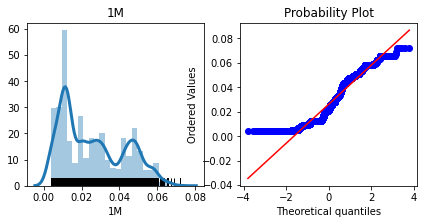

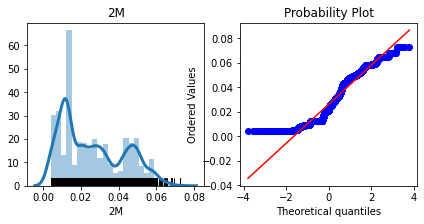

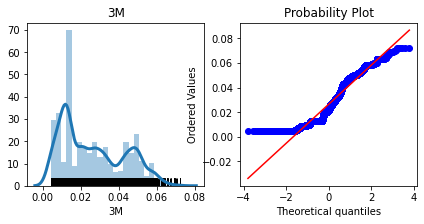

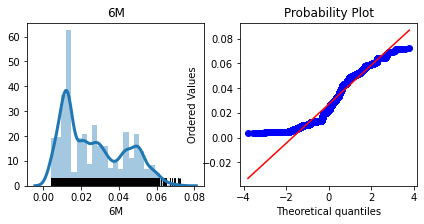

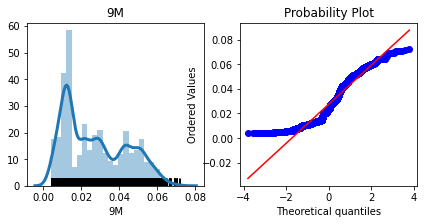

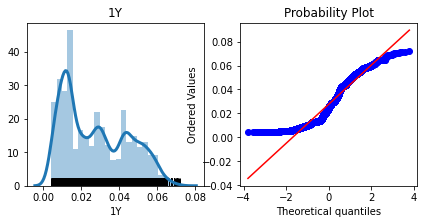

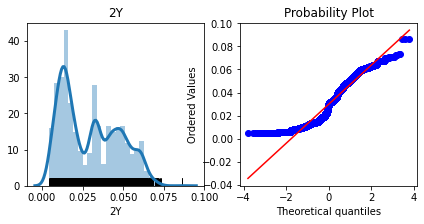

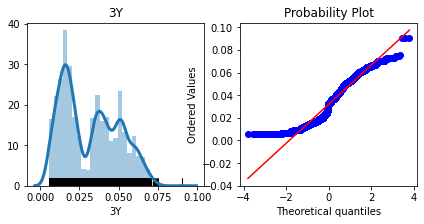

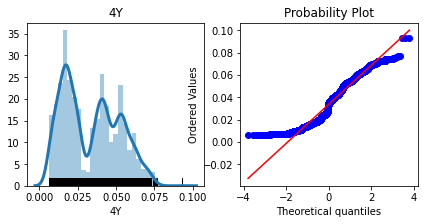

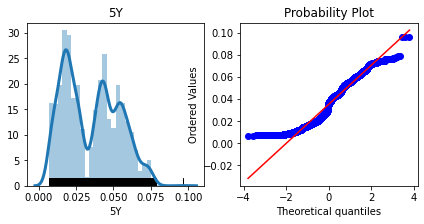

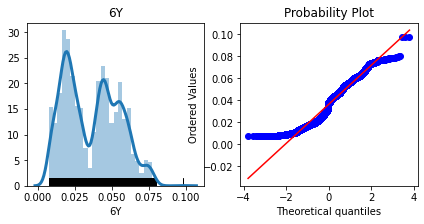

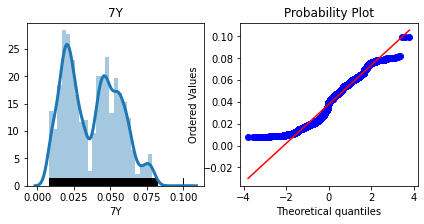

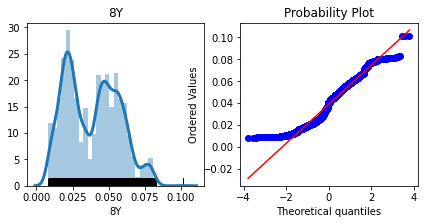

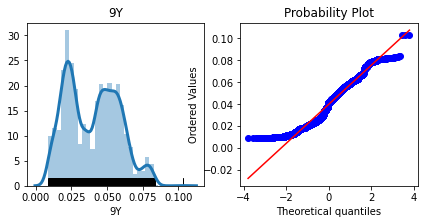

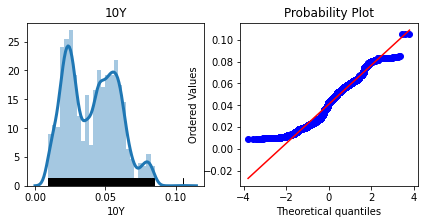

In [45]:
for i in df.columns:
    plt.figure(figsize=(7,3))
    plt.subplot(1,2,1)
    sns.distplot(df[i], hist = True, kde = True, rug = True,
             kde_kws={'linewidth': 3},
             rug_kws={'color': 'black'})
    plt.title(i)
    plt.subplot(1,2,2)
    stats.probplot(df[i], plot=plt);
    df[i].describe().T

## ADF test for stationarity of time series
- Null Hypotheiss is that the time series has unit root and is not stationary.

- We find that the TS is not stationary and hence differencing is needed to model it.

In [269]:
def augmented_dickey_fuller_statistics(time_series):
    result = adfuller(time_series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
for i in df.columns:
    print('Augmented Dickey-Fuller Test:',i)
    augmented_dickey_fuller_statistics(df[i])

Augmented Dickey-Fuller Test: 1M
ADF Statistic: -2.096350
p-value: 0.245985
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Augmented Dickey-Fuller Test: 2M
ADF Statistic: -2.051839
p-value: 0.264316
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Augmented Dickey-Fuller Test: 3M
ADF Statistic: -1.990226
p-value: 0.290875
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Augmented Dickey-Fuller Test: 6M
ADF Statistic: -1.947272
p-value: 0.310160
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Augmented Dickey-Fuller Test: 9M
ADF Statistic: -1.935518
p-value: 0.315541
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Augmented Dickey-Fuller Test: 1Y
ADF Statistic: -1.873723
p-value: 0.344522
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Augmented Dickey-Fuller Test: 2Y
ADF Statistic: -1.906908
p-value: 0.328818
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Augmented Dickey-Fuller Test: 3Y
ADF Statistic: -1.883746
p-value: 0.339746
Critical Value

## Distribution after differencing

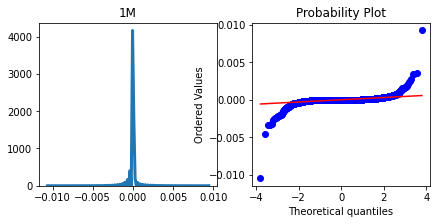

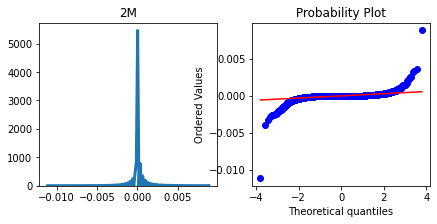

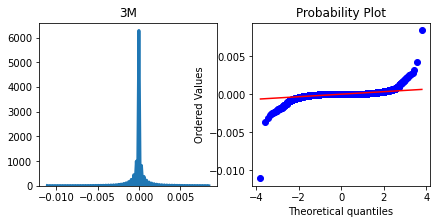

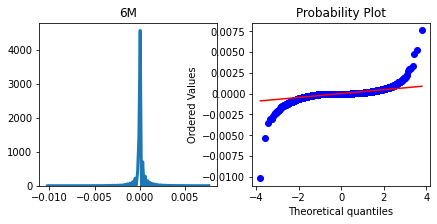

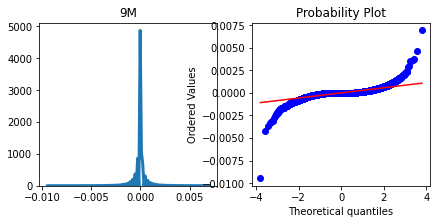

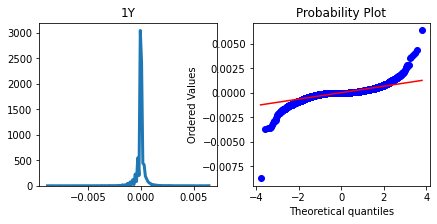

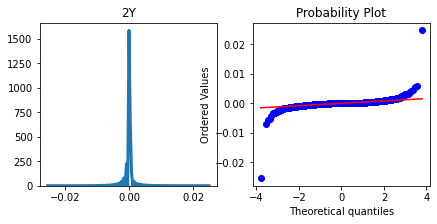

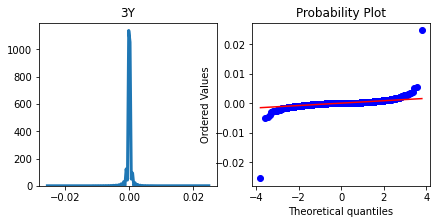

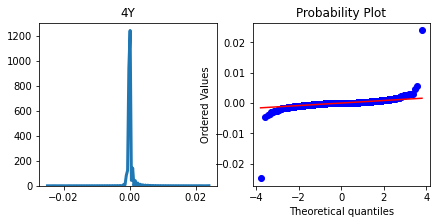

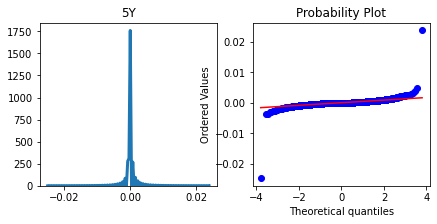

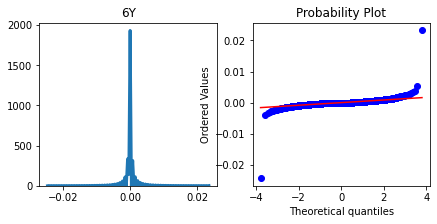

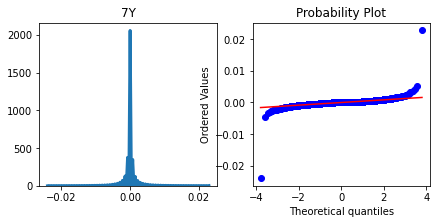

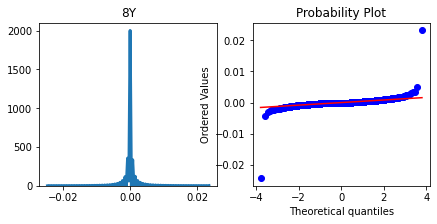

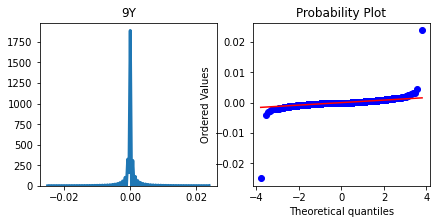

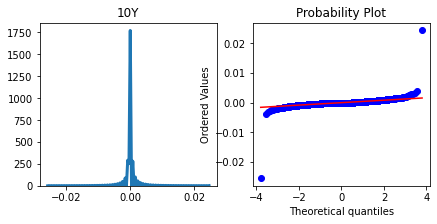

In [8]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff
for i in df.columns:
    plt.figure(figsize=(7,3))
    plt.subplot(1,2,1)
    sns.distplot(difference(df[i]), hist = False, kde = True,kde_kws={'linewidth': 3})
    plt.title(i)
    plt.subplot(1,2,2)
    stats.probplot(difference(df[i]), plot=plt);
    df[i].diff().describe().T

## ADF test after differencing. The time series is stationary after differencing

In [118]:
def augmented_dickey_fuller_statistics(time_series):
    result = adfuller(time_series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
for i in X_diff.columns:
    print('Augmented Dickey-Fuller Test:',i)
    augmented_dickey_fuller_statistics(X_diff[i])
    
        


Augmented Dickey-Fuller Test: 1M
ADF Statistic: -12.299391
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Augmented Dickey-Fuller Test: 2M
ADF Statistic: -11.744564
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Augmented Dickey-Fuller Test: 3M
ADF Statistic: -11.692931
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Augmented Dickey-Fuller Test: 6M
ADF Statistic: -15.069950
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Augmented Dickey-Fuller Test: 9M
ADF Statistic: -14.015939
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Augmented Dickey-Fuller Test: 1Y
ADF Statistic: -14.752682
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Augmented Dickey-Fuller Test: 2Y
ADF Statistic: -15.294891
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Augmented Dickey-Fuller Test: 3Y
ADF Statistic: -17.249975
p-value: 0.000000
Critic

## ACF and PACF plot to further analyse the time series

- We deduce that the process in an autoregressive (AR) proces for all the time series

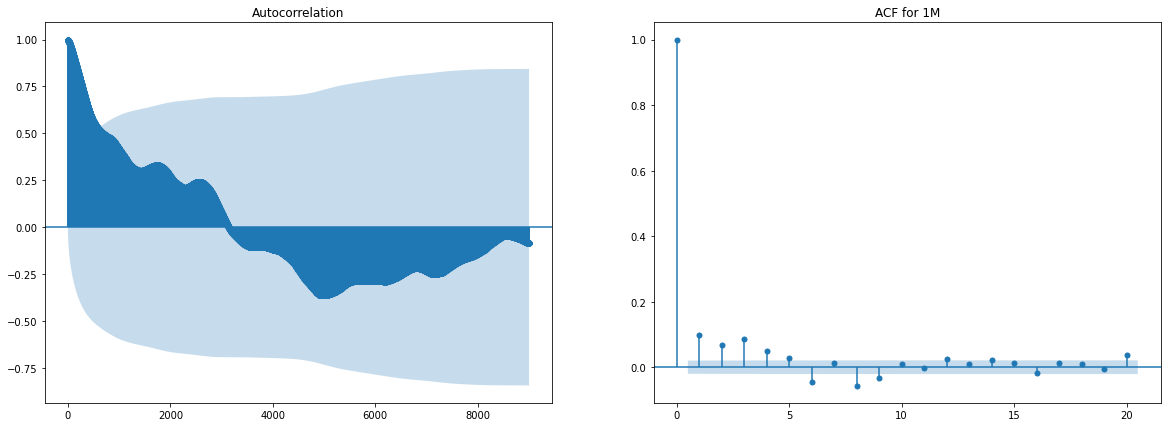

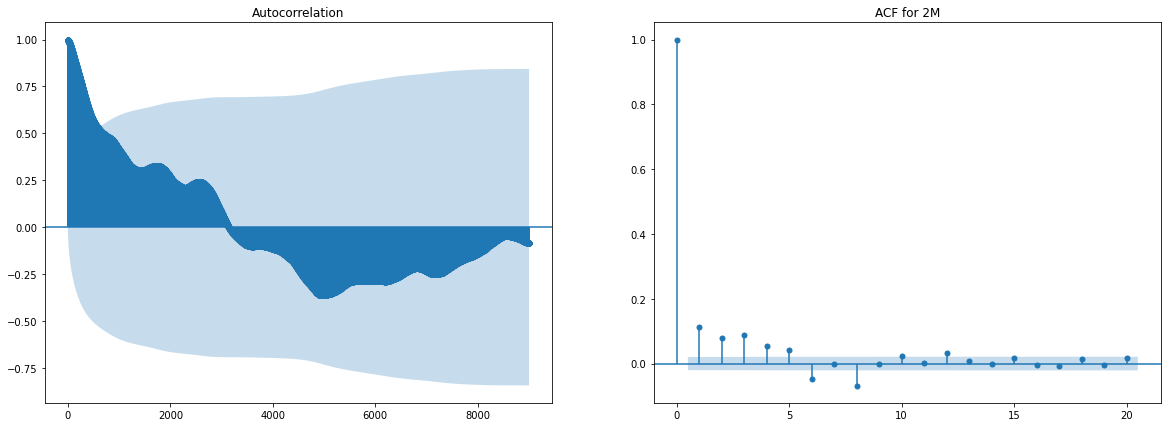

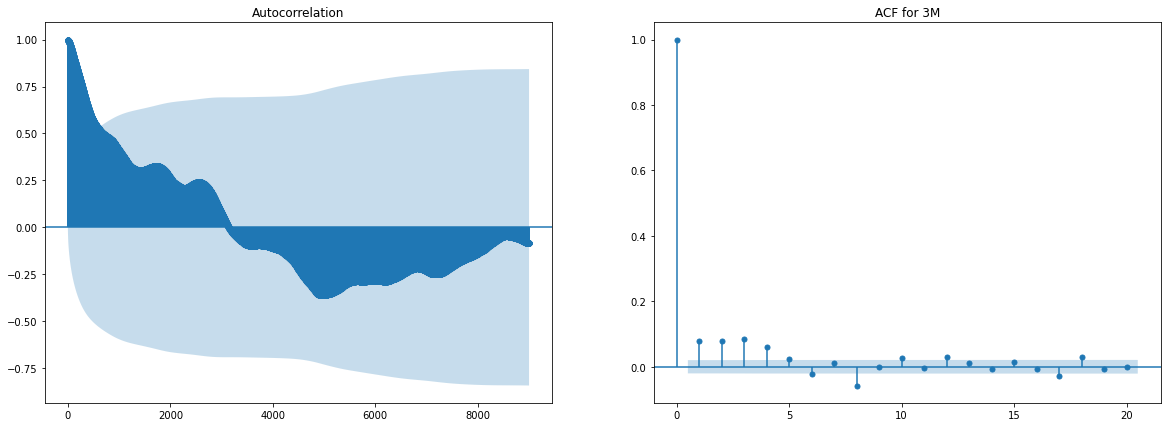

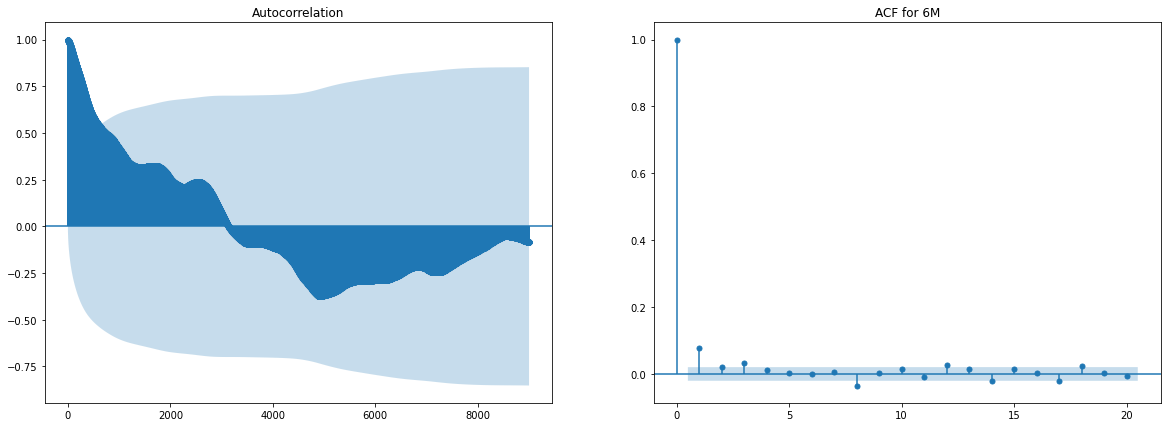

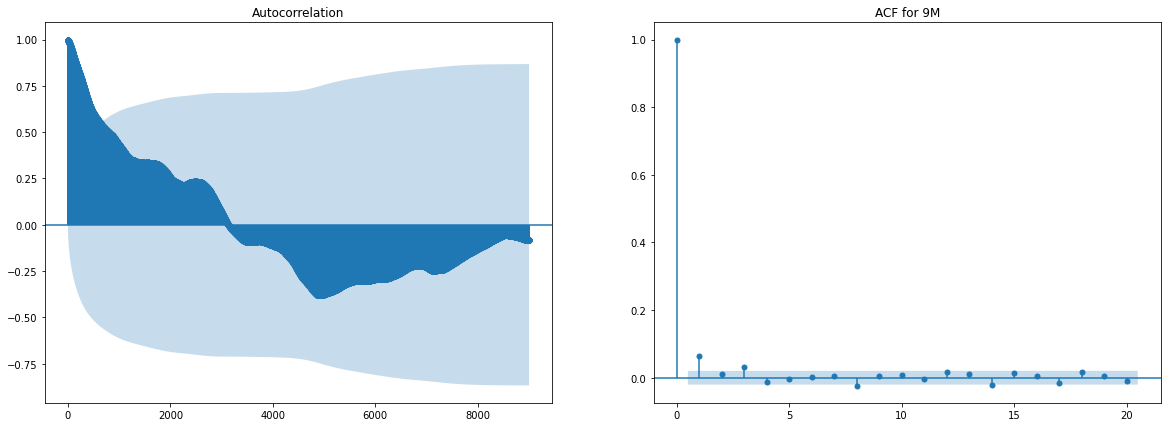

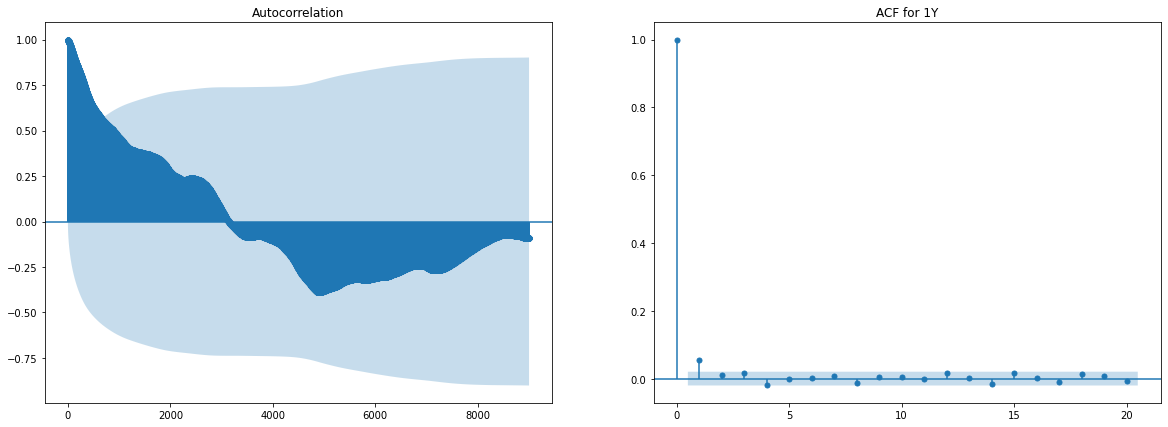

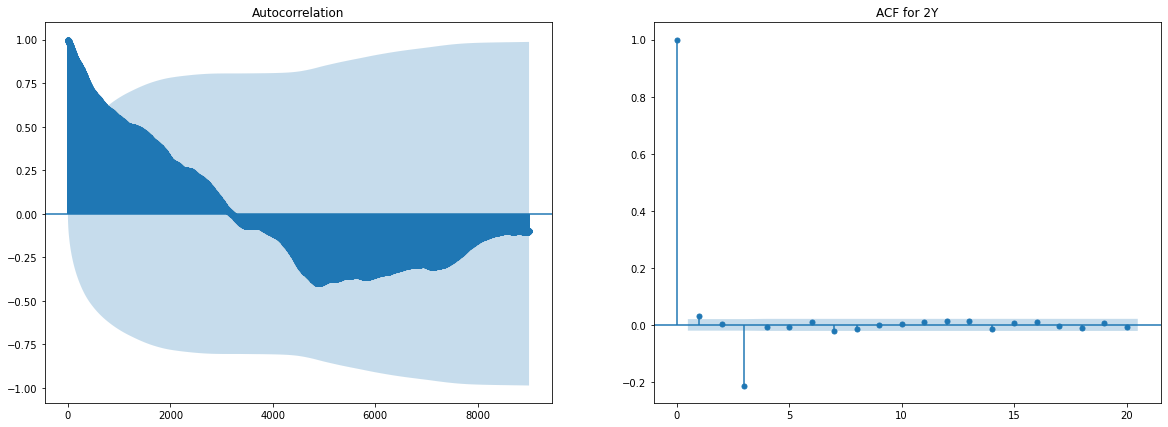

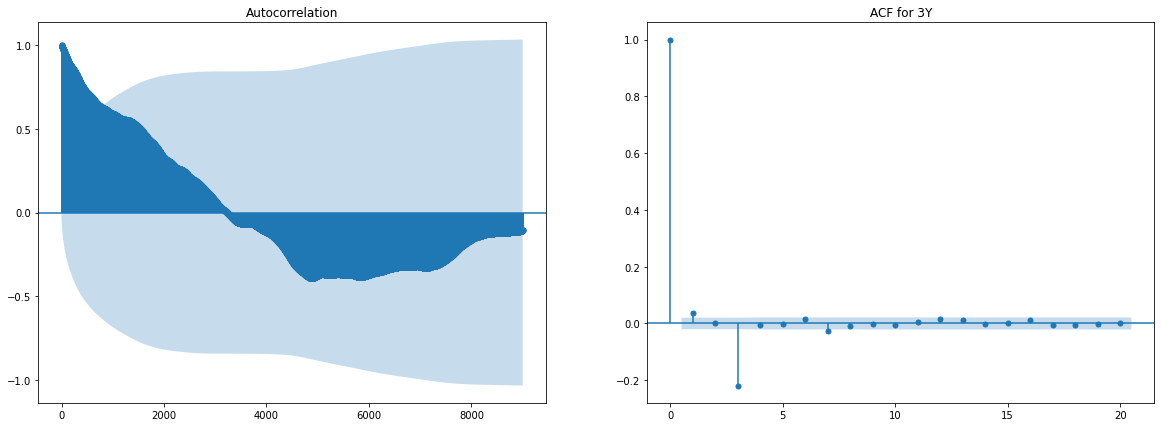

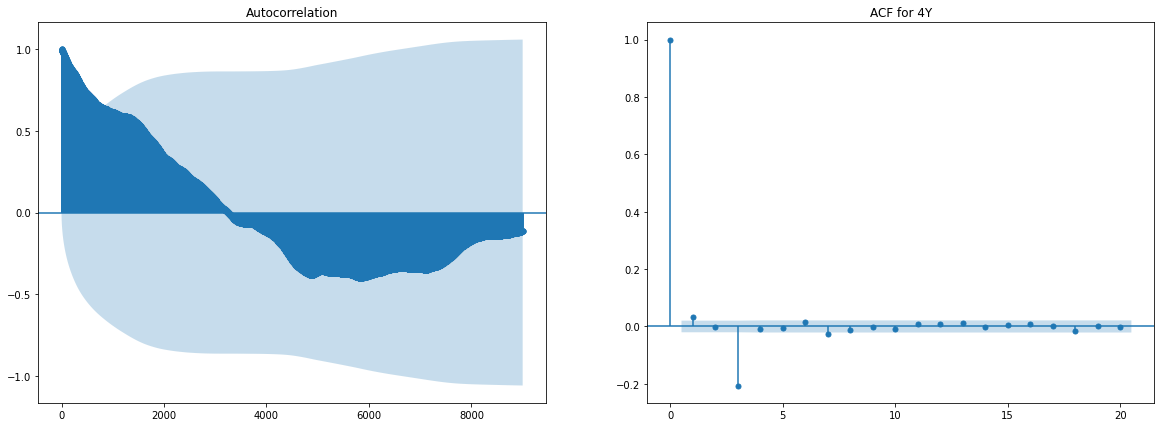

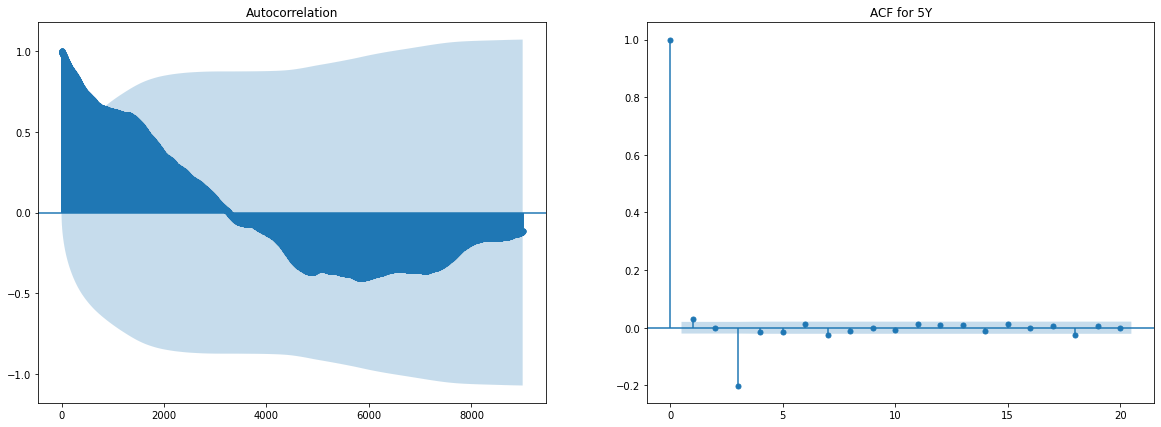

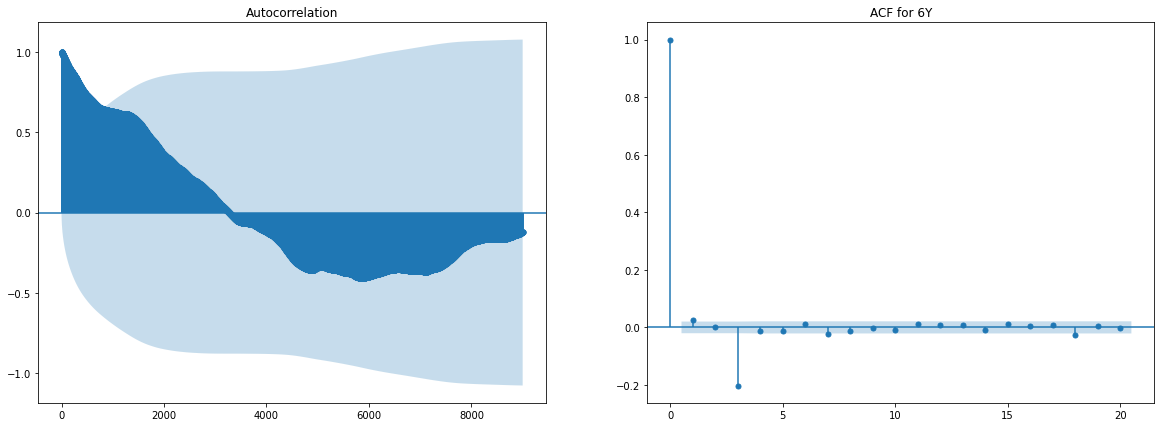

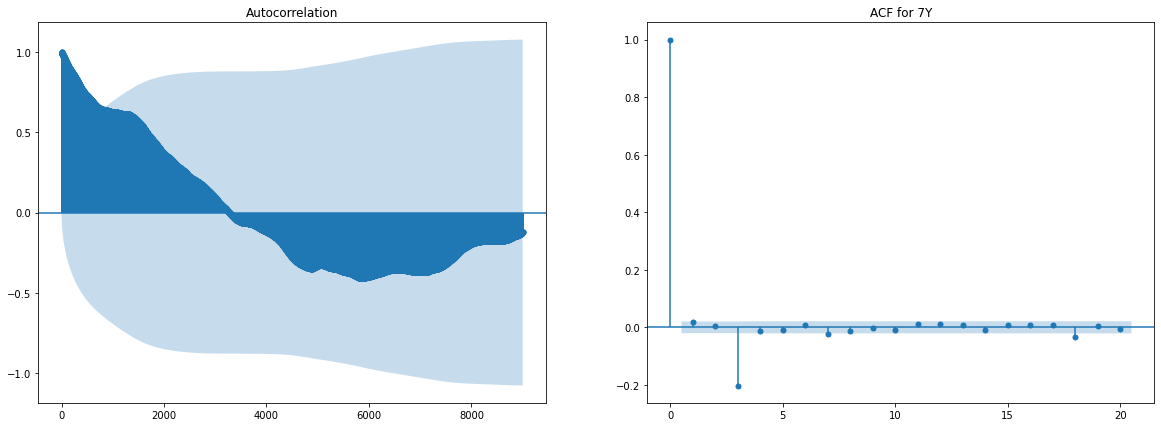

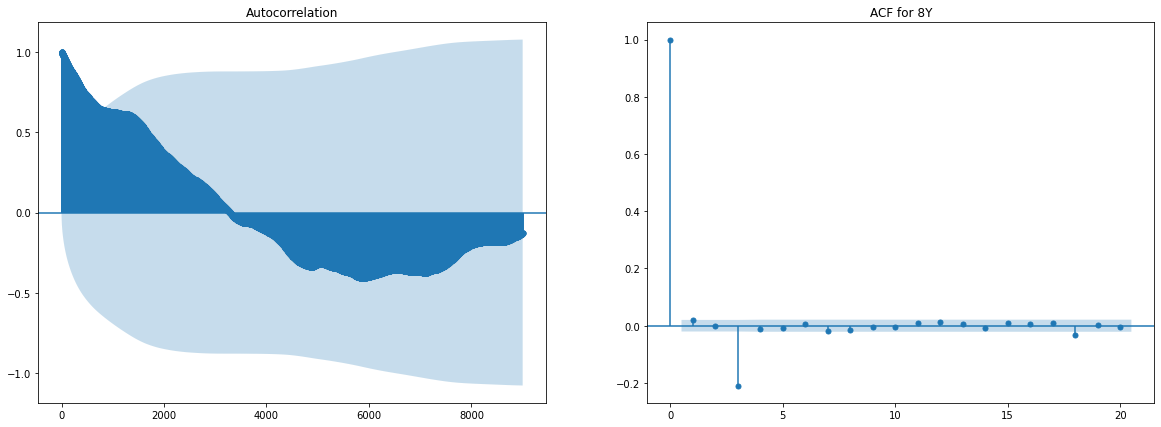

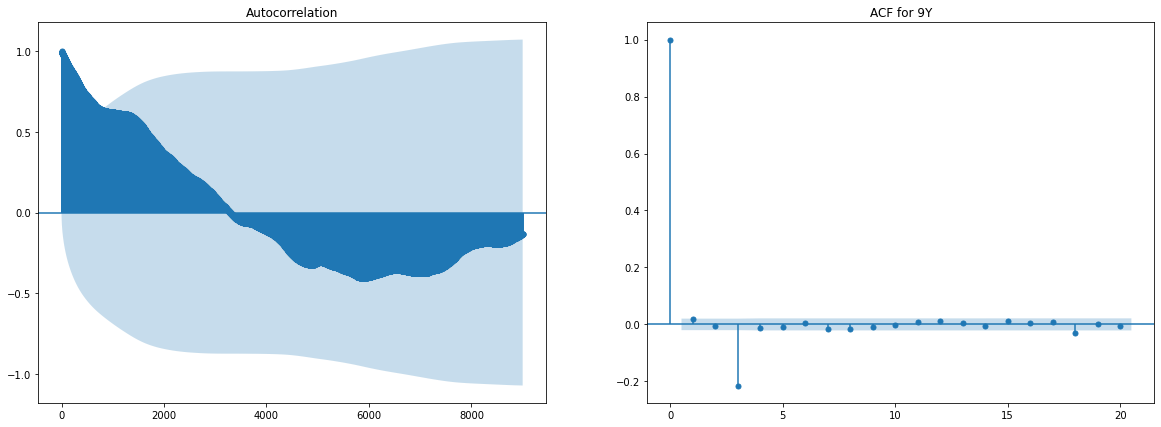

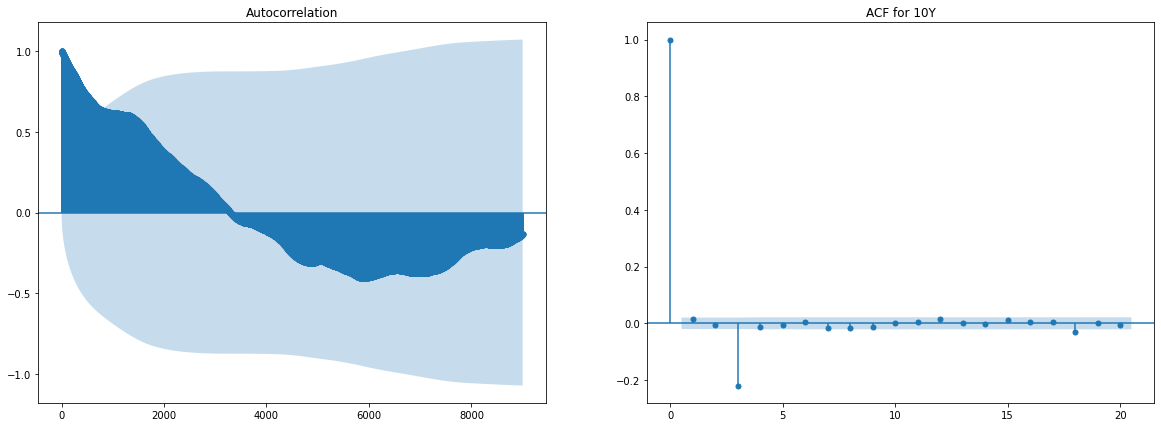

In [43]:
for i in df:
    plt.rcParams["figure.figsize"] = (20,7)
    fig,ax = plt.subplots(1,2)
    sm.graphics.tsa.plot_acf(df[i],lags=9000,ax=ax[0])
    plt.title('ACF for %s' % i)
    sm.graphics.tsa.plot_acf(difference(df[i]),lags=20,ax=ax[1])
    plt.title('ACF for %s' % i)
    plt.show()

<Figure size 1080x216 with 0 Axes>

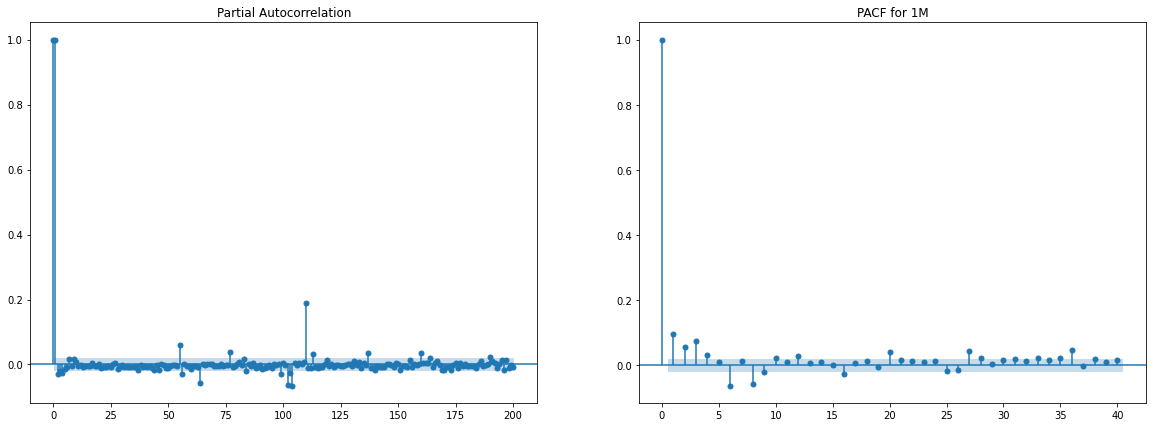

<Figure size 1080x216 with 0 Axes>

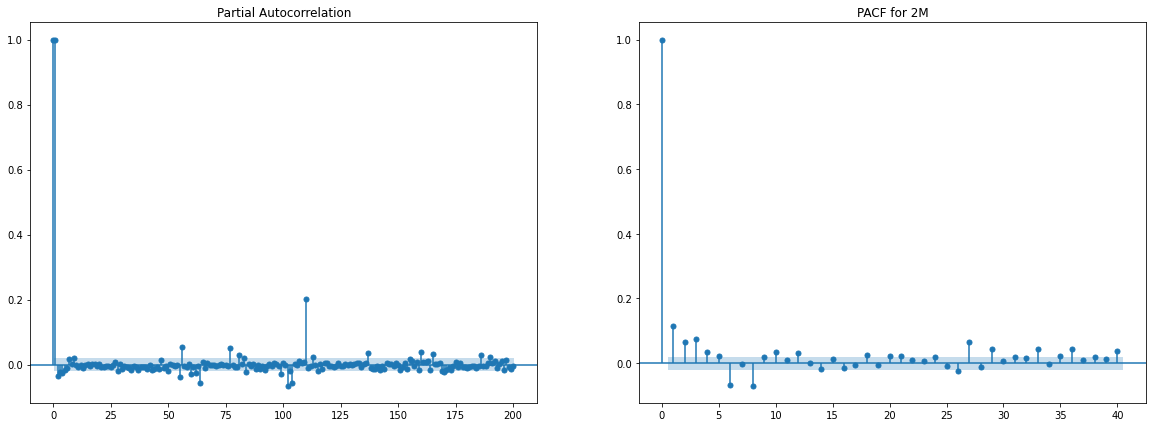

<Figure size 1080x216 with 0 Axes>

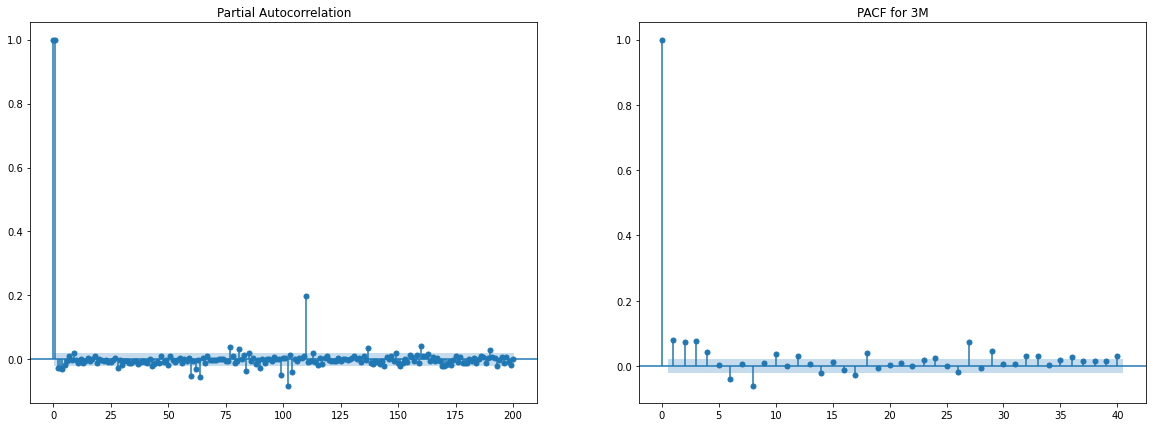

<Figure size 1080x216 with 0 Axes>

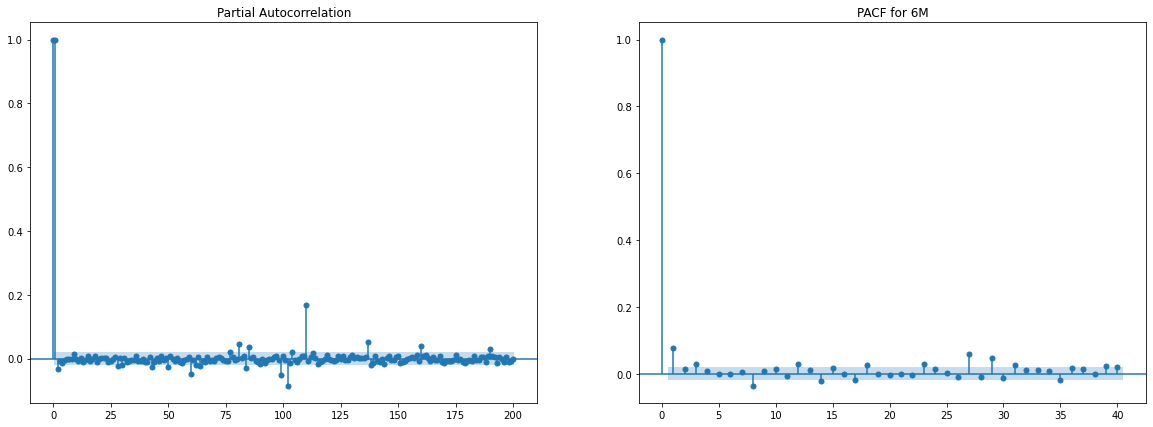

<Figure size 1080x216 with 0 Axes>

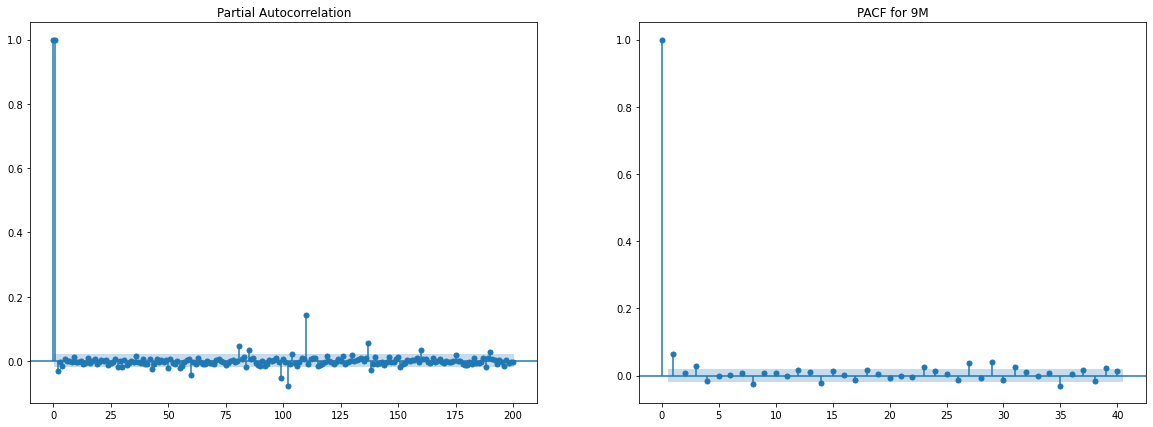

<Figure size 1080x216 with 0 Axes>

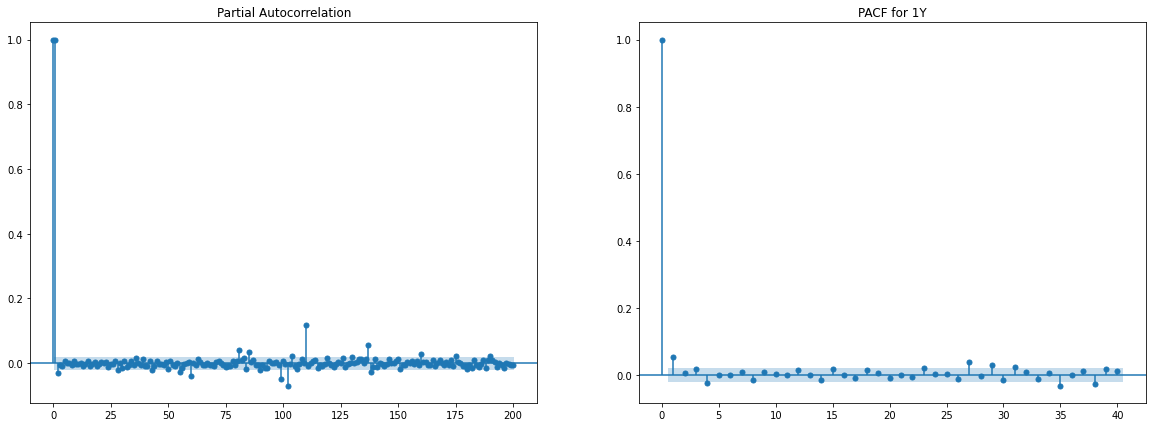

<Figure size 1080x216 with 0 Axes>

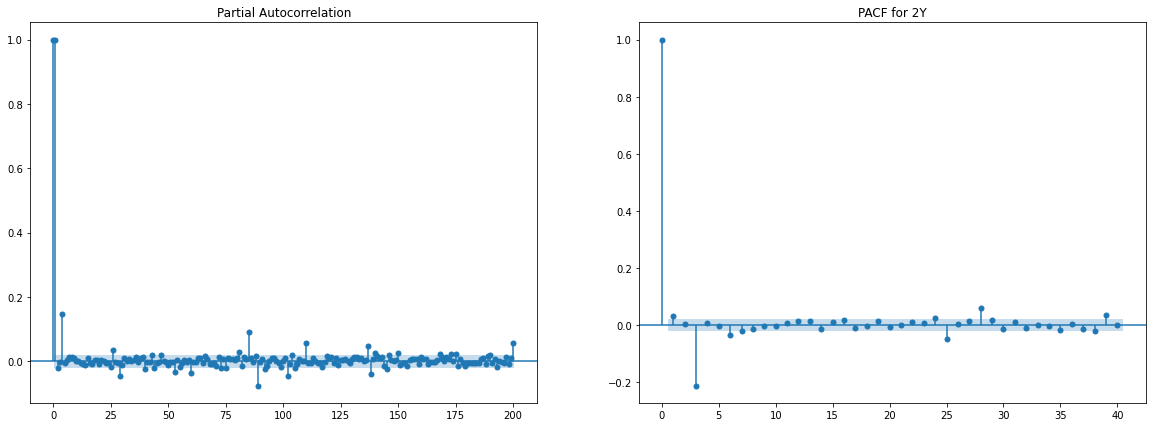

<Figure size 1080x216 with 0 Axes>

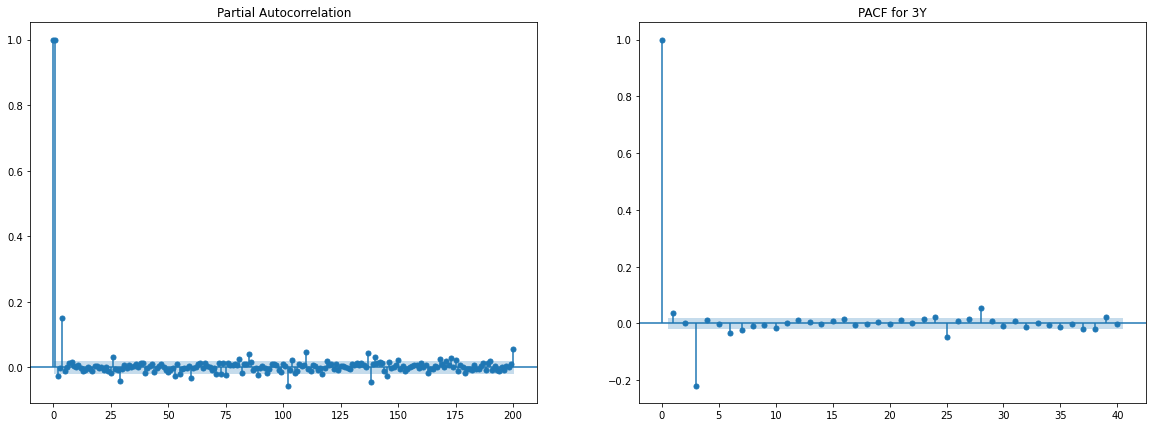

<Figure size 1080x216 with 0 Axes>

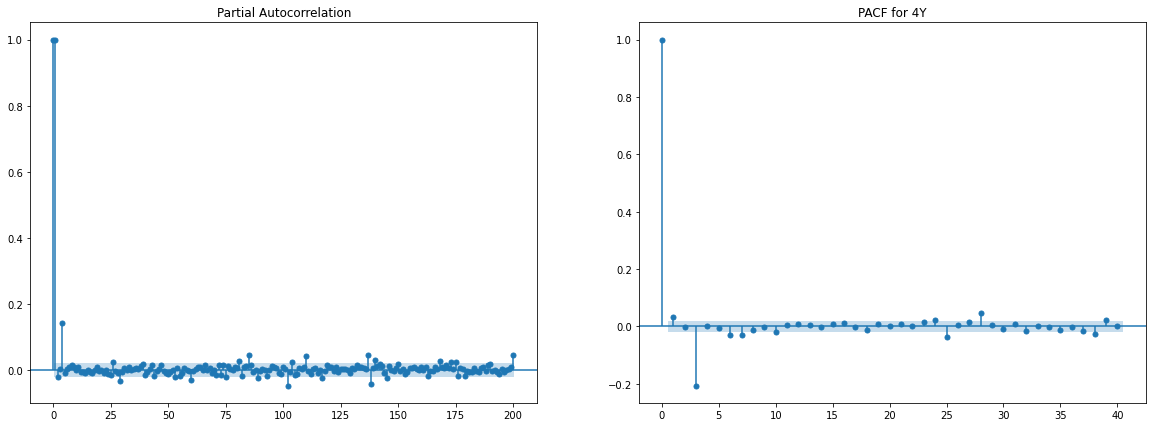

<Figure size 1080x216 with 0 Axes>

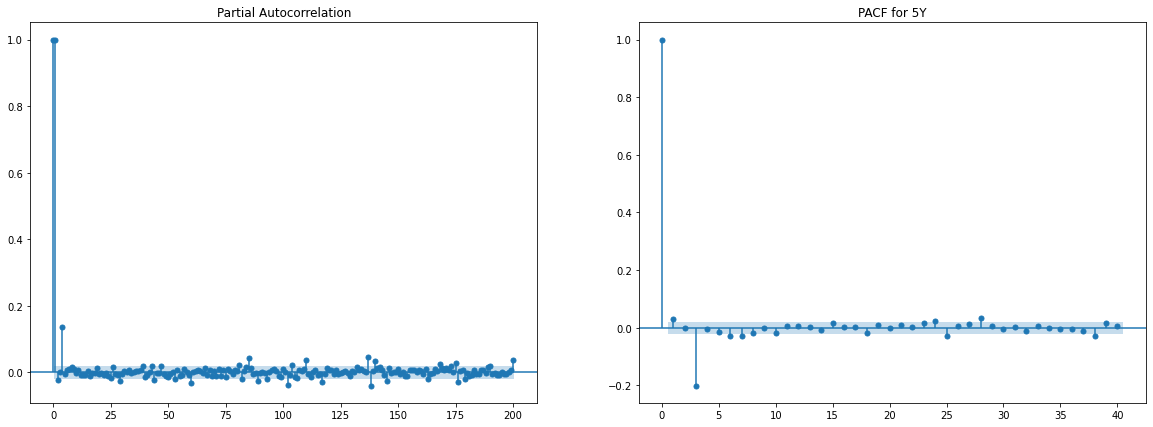

<Figure size 1080x216 with 0 Axes>

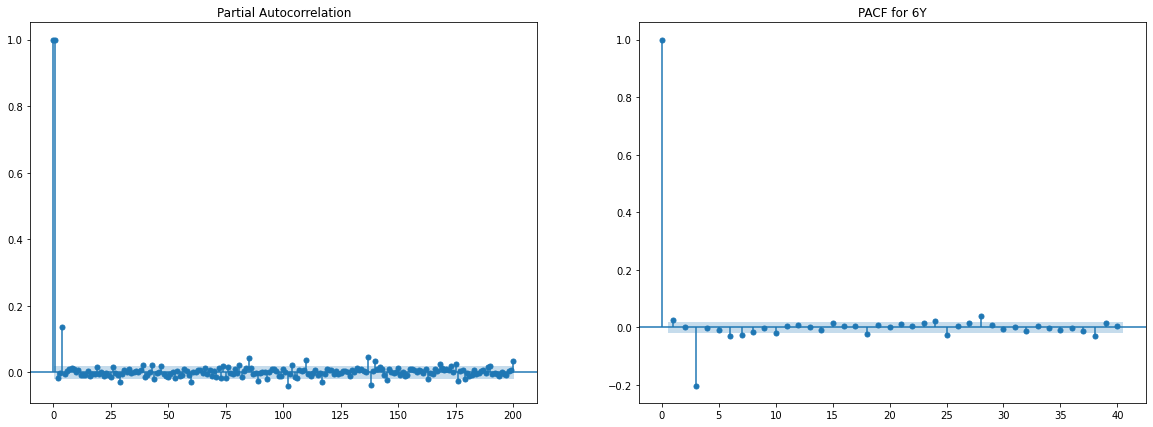

<Figure size 1080x216 with 0 Axes>

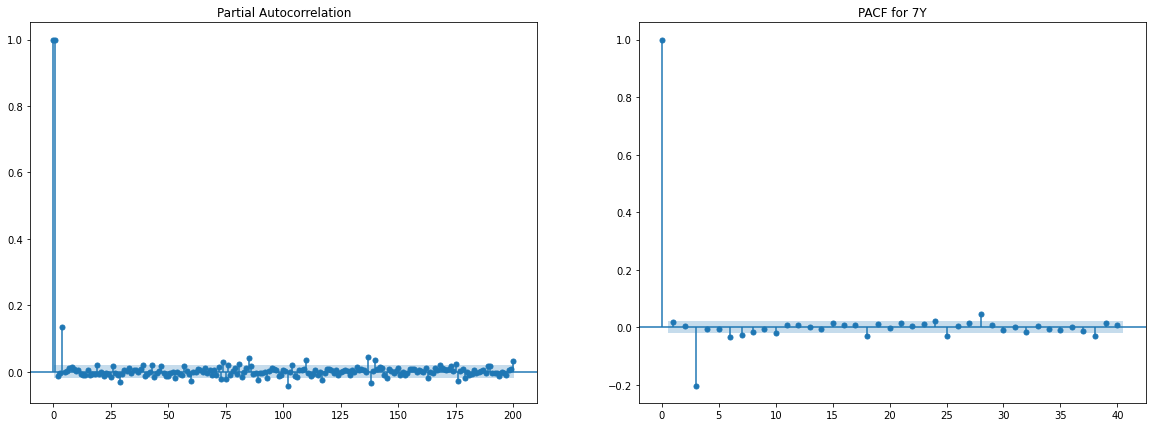

<Figure size 1080x216 with 0 Axes>

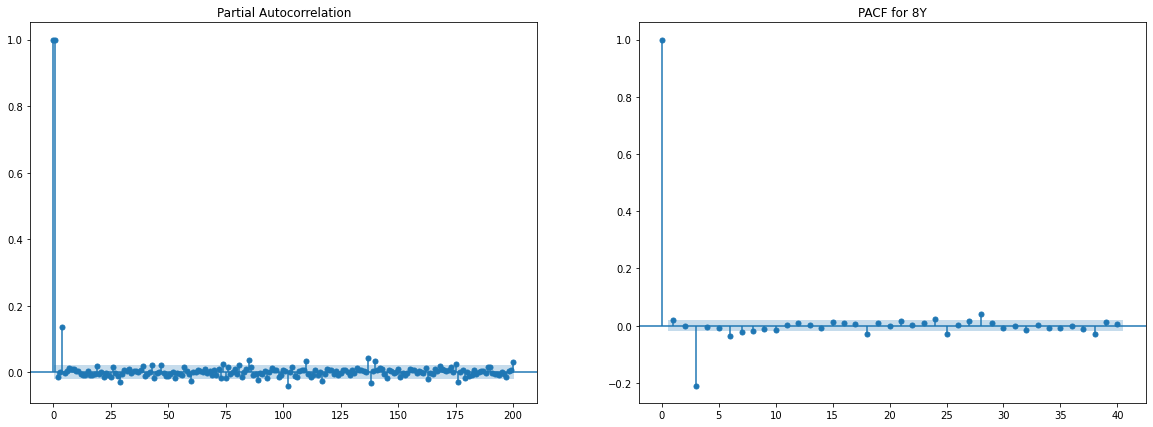

<Figure size 1080x216 with 0 Axes>

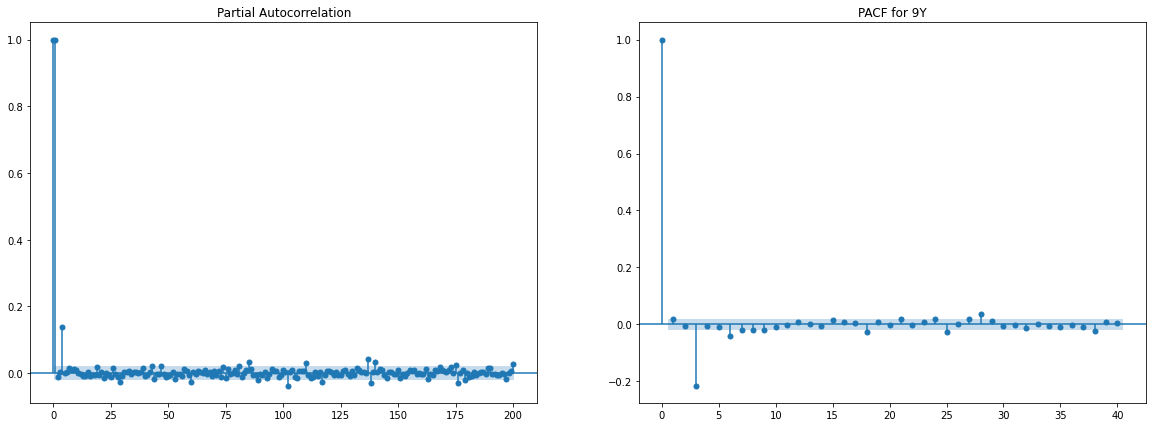

<Figure size 1080x216 with 0 Axes>

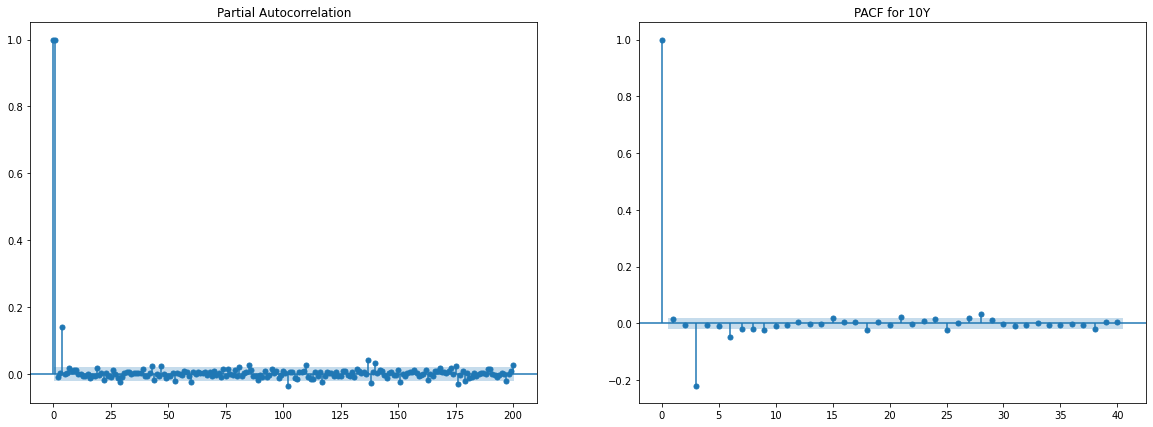

In [44]:
for i in df:
    plt.figure(figsize=(15,3))
    fig,ax = plt.subplots(1,2)
    sm.graphics.tsa.plot_pacf(df[i], lags = 200,ax=ax[0])
    plt.title('PACF for %s' % i)
    sm.graphics.tsa.plot_pacf(difference(df[i]), lags = 40,ax=ax[1])
    plt.title('PACF for %s' % i)

## Dividing the time series into test and train sets and transforming the train set. by differencing to make it stationary.

In [151]:
X_train=df[:-19]
X_test=df[-19:]
print(X_train.shape)
print(X_test.shape)
X_diff=X_train.diff().dropna()
print(X_diff.shape)

(9343, 15)
(19, 15)
(9342, 15)


In [152]:
X_diff.describe()

1M           2M           3M           6M           9M  \
count  9342.000000  9342.000000  9342.000000  9342.000000  9342.000000   
mean     -0.000007    -0.000006    -0.000006    -0.000006    -0.000006   
std       0.000265     0.000260     0.000272     0.000319     0.000358   
min      -0.010505    -0.011137    -0.011075    -0.010208    -0.009474   
25%       0.000000     0.000000    -0.000003    -0.000020    -0.000030   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000005     0.000009     0.000025     0.000035   
max       0.009290     0.008860     0.008416     0.007625     0.006944   

                1Y           2Y           3Y           4Y           5Y  \
count  9342.000000  9342.000000  9342.000000  9342.000000  9342.000000   
mean     -0.000006    -0.000007    -0.000007    -0.000007    -0.000007   
std       0.000391     0.000573     0.000565     0.000560     0.000566   
min      -0.008755    -0.025444    -0.025514    -0.024772    -0.024886   
25%      -0.000069    -0.000094    -0.000109    -0.000127    -0.000146   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000068     0.000096     0.000100     0.000116     0.000123   
max       0.006370     0.024794     0.024736     0.023952     0.023854   

                6Y           7Y           8Y           9Y          10Y  
count  9342.000000  9342.000000  9342.000000  9342.000000  9342.000000  
mean     -0.000007    -0.000007    -0.000007    -0.000007    -0.000007  
std       0.000557     0.000550     0.000548     0.000549     0.000555  
min      -0.024398    -0.023961    -0.024418    -0.024939    -0.025530  
25%      -0.000149    -0.000152    -0.000153    -0.000156    -0.000160  
50%       0.000000     0.000000     0.000000     0.000000     0.000000  
75%       0.000124     0.000123     0.000119     0.000119     0.000119  
max       0.023326     0.022836     0.023312     0.023841     0.024439

## Visualizing the time series after differencing

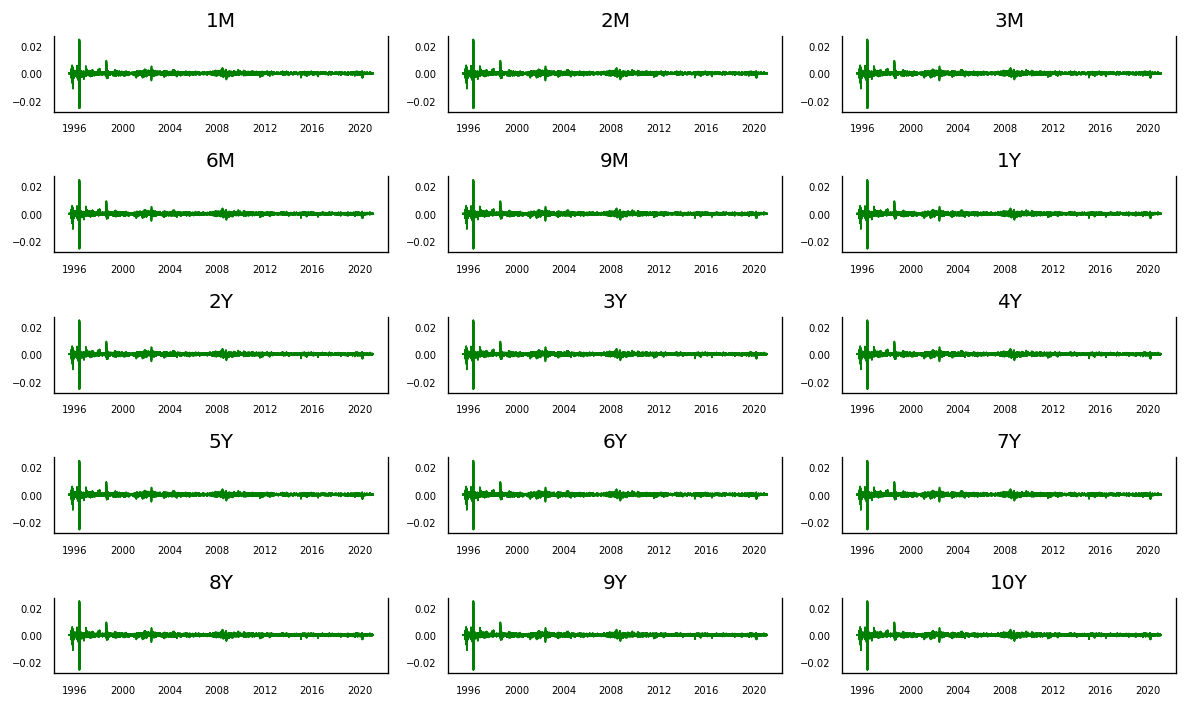

In [11]:
fig, axes = plt.subplots(nrows=5, ncols=3, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = X_diff[X_diff.columns[i]]
    ax.plot(X_diff, color='g', linewidth=1)
    ax.set_title(X_diff.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout();

## Granger’s causality Test
Granger’s causality Tests the null hypothesis that the coefficients of past values in the regression equation is zero.
So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, you can safely reject the null hypothesis. This has been performed on original data-set.

The basis behind Vector AutoRegression is that each of the time series in the system influences each other. That is, we can predict the series with past values of itself along with other series in the system.

### Since, the p value is less tha 0.05 we can reject null hypothesis and say that the coefficients of past values in the regression equation is not zero.

In [12]:
def grangers_causality_matrix(data, variables, test = 'ssr_chi2test', verbose=False):

    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(data[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')

            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value

    dataset.columns = [var + '_x' for var in variables]

    dataset.index = [var + '_y' for var in variables]

    return dataset

maxlag=19
grangers_causality_matrix(X_diff, variables = X_diff.columns)

1M_x    2M_x  3M_x    6M_x    9M_x    1Y_x    2Y_x    3Y_x    4Y_x  \
1M_y   1.0000  0.0000   0.0  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
2M_y   0.0000  1.0000   0.0  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
3M_y   0.0000  0.0000   1.0  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
6M_y   0.0000  0.0000   0.0  1.0000  0.0000  0.0001  0.0000  0.0000  0.0000   
9M_y   0.0000  0.0000   0.0  0.0000  1.0000  0.0158  0.0008  0.0004  0.0006   
1Y_y   0.0000  0.0000   0.0  0.0001  0.0001  1.0000  0.0000  0.0002  0.0001   
2Y_y   0.0000  0.0000   0.0  0.0000  0.0000  0.0000  1.0000  0.0000  0.0104   
3Y_y   0.0000  0.0000   0.0  0.0000  0.0000  0.0000  0.0000  1.0000  0.0001   
4Y_y   0.0000  0.0000   0.0  0.0000  0.0000  0.0000  0.0000  0.0000  1.0000   
5Y_y   0.0000  0.0000   0.0  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
6Y_y   0.0001  0.0000   0.0  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
7Y_y   0.0005  0.0000   0.0  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
8Y_y   0.0019  0.0000   0.0  0.0000  0.0000  0.0000  0.0000  0.0000  0.0010   
9Y_y   0.0068  0.0001   0.0  0.0000  0.0000  0.0000  0.0000  0.0000  0.0004   
10Y_y  0.0188  0.0004   0.0  0.0000  0.0000  0.0000  0.0000  0.0000  0.0001   

         5Y_x    6Y_x    7Y_x    8Y_x    9Y_x   10Y_x  
1M_y   0.0000  0.0000  0.0000  0.0000  0.0000  0.0001  
2M_y   0.0000  0.0000  0.0000  0.0000  0.0000  0.0001  
3M_y   0.0000  0.0000  0.0000  0.0000  0.0002  0.0009  
6M_y   0.0000  0.0001  0.0006  0.0027  0.0136  0.0321  
9M_y   0.0011  0.0048  0.0088  0.0296  0.0816  0.0970  
1Y_y   0.0001  0.0009  0.0019  0.0072  0.0261  0.0505  
2Y_y   0.0917  0.0251  0.0017  0.0000  0.0000  0.0000  
3Y_y   0.0000  0.0020  0.0090  0.0011  0.0000  0.0000  
4Y_y   0.0000  0.0095  0.0163  0.0005  0.0000  0.0000  
5Y_y   1.0000  0.0004  0.0005  0.0000  0.0000  0.0000  
6Y_y   0.0000  1.0000  0.0000  0.0000  0.0000  0.0000  
7Y_y   0.0000  0.0000  1.0000  0.0000  0.0000  0.0000  
8Y_y   0.0018  0.0067  0.0000  1.0000  0.0000  0.0000  
9Y_y   0.0077  0.0055  0.0001  0.0001  1.0000  0.0023  
10Y_y  0.0068  0.0127  0.0020  0.0036  0.0090  1.0000

## Using VAR model

In [170]:
#The Akaike information criterion is a mathematical test used to evaluate how well a model fits the data it 
#is meant to describe. It penalizes models which use more independent variables (parameters) as a way to 
#avoid over-fitting. AIC is most often used to compare the relative goodness-of-fit among different models 
#under consideration and to then choose the model that best fits the data.
mod = VAR(X_diff)
for i in np.arange(1,90):
    result = mod.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)

Lag Order = 1
AIC :  -283.2284009586659
Lag Order = 2
AIC :  -283.3882184921024
Lag Order = 3
AIC :  -283.77058933939634
Lag Order = 4
AIC :  -283.93121924608903
Lag Order = 5
AIC :  -284.0760861792927
Lag Order = 6
AIC :  -284.2342265593207
Lag Order = 7
AIC :  -284.336546076346
Lag Order = 8
AIC :  -284.38155206308375
Lag Order = 9
AIC :  -284.4270315232759
Lag Order = 10
AIC :  -284.46006538152346
Lag Order = 11
AIC :  -284.4854862043449
Lag Order = 12
AIC :  -284.5377149818556
Lag Order = 13
AIC :  -284.5987850439742
Lag Order = 14
AIC :  -284.669525792346
Lag Order = 15
AIC :  -284.70622944194315
Lag Order = 16
AIC :  -284.7283511582743
Lag Order = 17
AIC :  -284.74043864765144
Lag Order = 18
AIC :  -284.7583012797358
Lag Order = 19
AIC :  -284.77678228577656
Lag Order = 20
AIC :  -284.8024408568064
Lag Order = 21
AIC :  -284.9040767331158
Lag Order = 22
AIC :  -284.9318658244586
Lag Order = 23
AIC :  -284.9450720260227
Lag Order = 24
AIC :  -284.9518332324718
Lag Order = 25
AIC :

In [153]:
mod = VAR(X_diff)
res = mod.fit(maxlags=30, ic='aic')
print(res.summary())
y_fitted = res.fittedvalues

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 05, Aug, 2021
Time:                     10:28:22
--------------------------------------------------------------------
No. of Equations:         15.0000    BIC:                   -280.045
Nobs:                     9312.00    HQIC:                  -283.470
Log likelihood:       1.13661e+06    FPE:               1.33674e-124
AIC:                     -285.231    Det(Omega_mle):    6.57570e-125
--------------------------------------------------------------------
Results for equation 1M
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const          -0.000003         0.000002           -1.345           0.179
L1.1M          -0.067766         0.028204           -2.403           0.016
L1.2M           0.007266         0.048384            0.150           0.881
L1.3M       

## Finding residuals and performing whiteness test

### If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model. In that case, the typical course of action is to either increase the order of the model or induce more predictors into the system or look for a different algorithm to model the time series.

The residuals should follow the following:
- They should be uncorrelated.
- They should have mean around 0
- They should have constant variance.
- They should be normally distributed

### From the plot below we can see that the variance is constant and mean is around 0

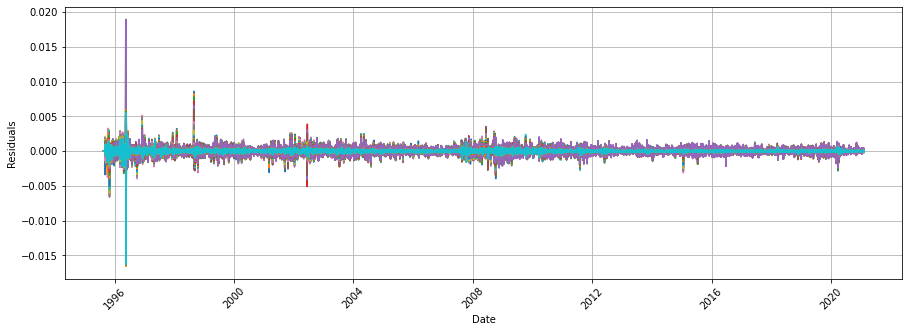

In [154]:
residuals= res.resid
plt.figure(figsize = (15,5))
plt.plot(residuals, label='resid')
plt.plot(y_fitted, label='VAR prediction')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Residuals')
plt.grid(True)

### The residuals have a gaussian distribution as well

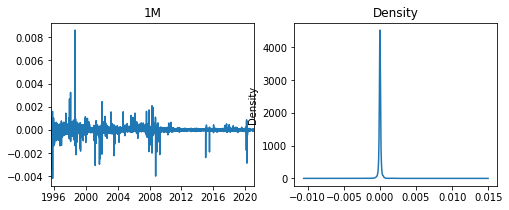

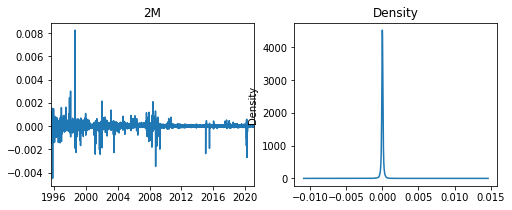

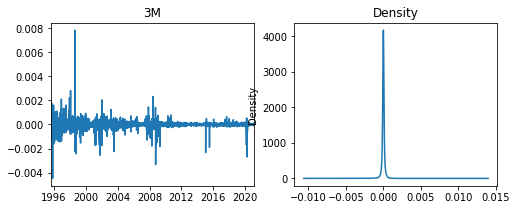

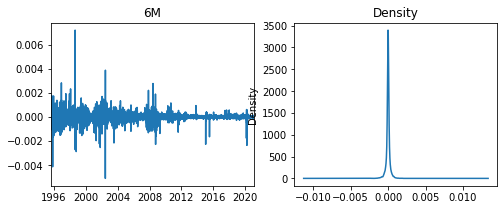

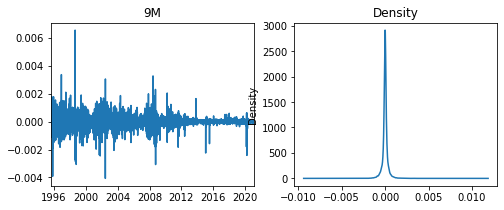

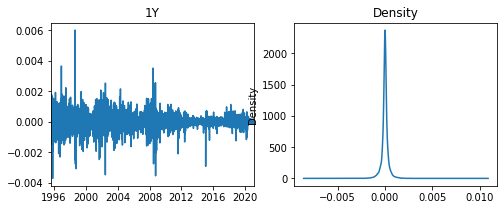

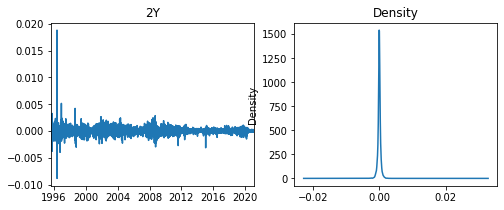

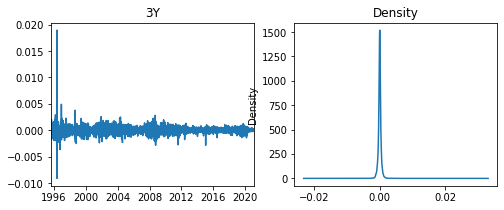

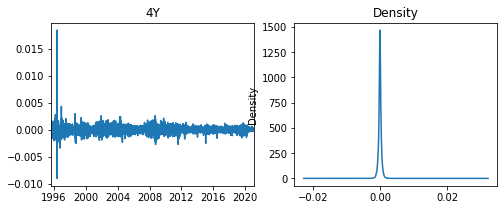

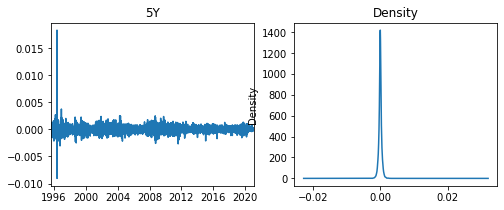

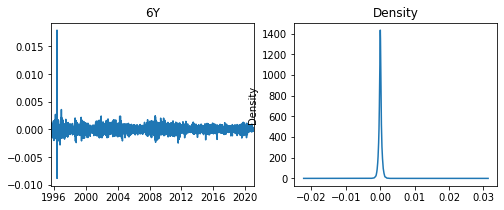

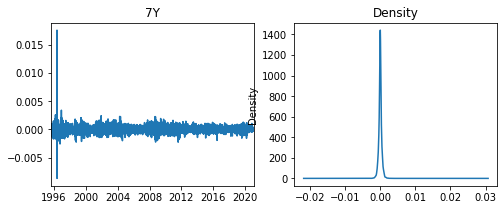

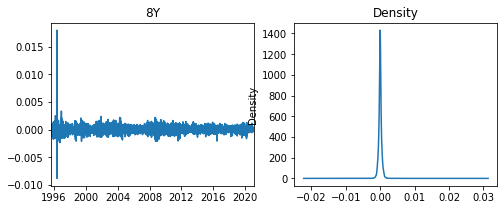

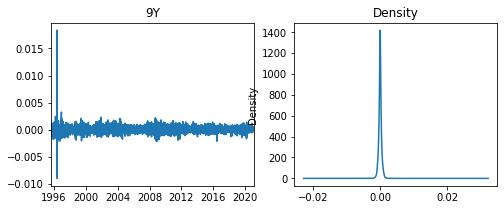

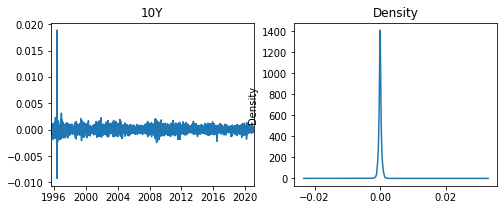

In [108]:
#re = invert_transformation_re(X_train, residuals)
for i in residuals.columns:
    r=residuals[i]
    #print(re.mean())
    plt.rcParams["figure.figsize"] = (8,3)
    fig,ax = plt.subplots(1,2)
    r.plot(title=i,ax=ax[0])
    r.plot(kind='kde',title="Density",ax=ax[1])
    plt.show()
    

## The residuals are not correlated as we can see from the ACF plot they are under the confidence interval

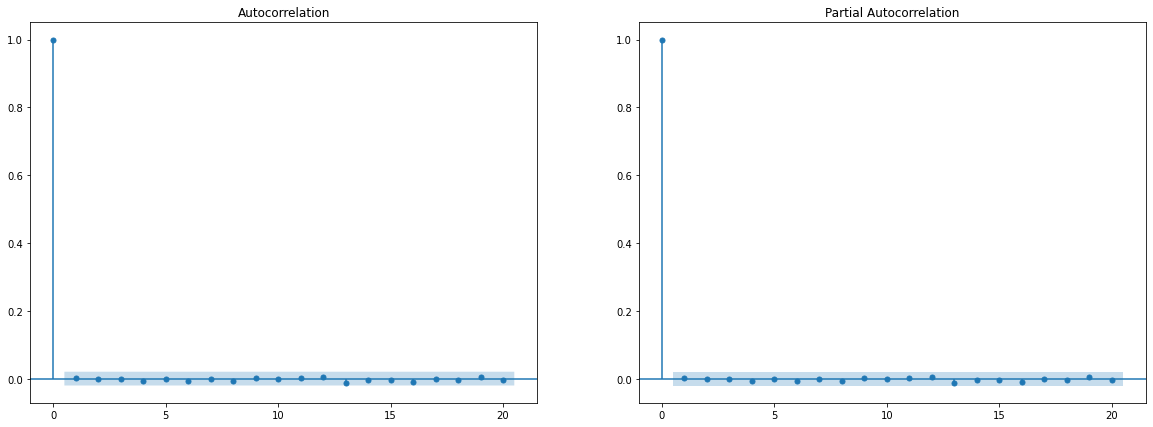

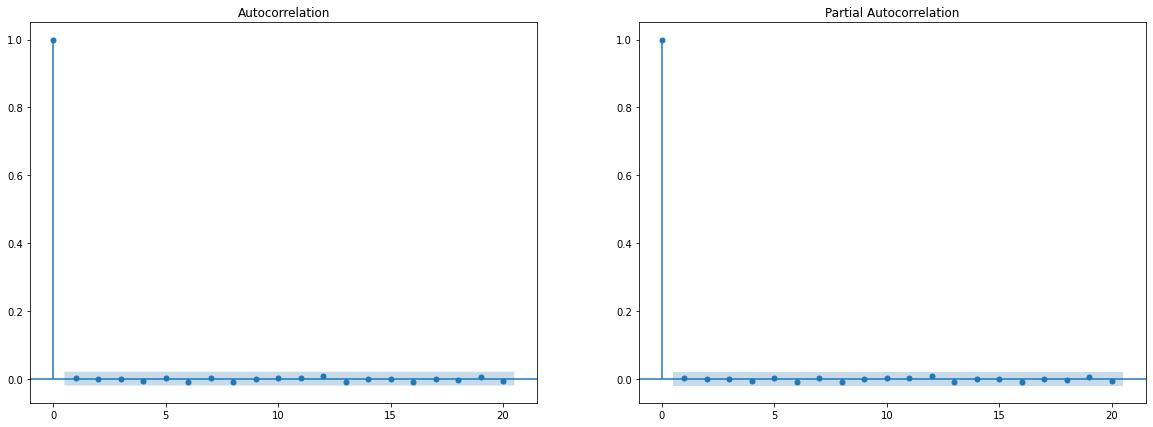

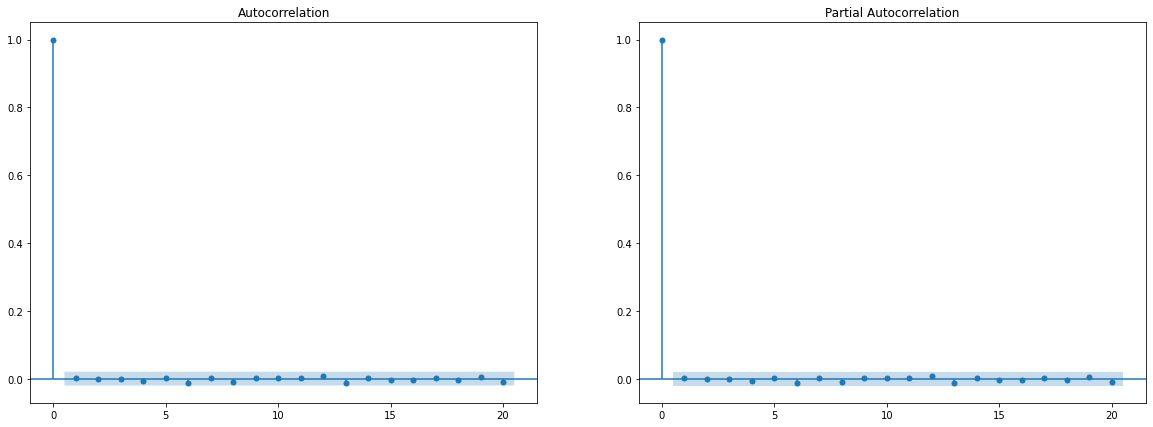

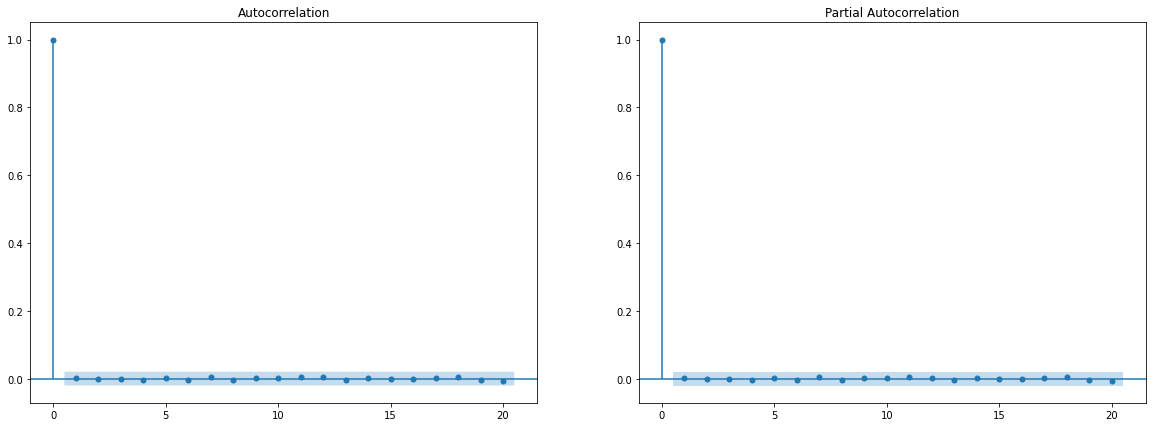

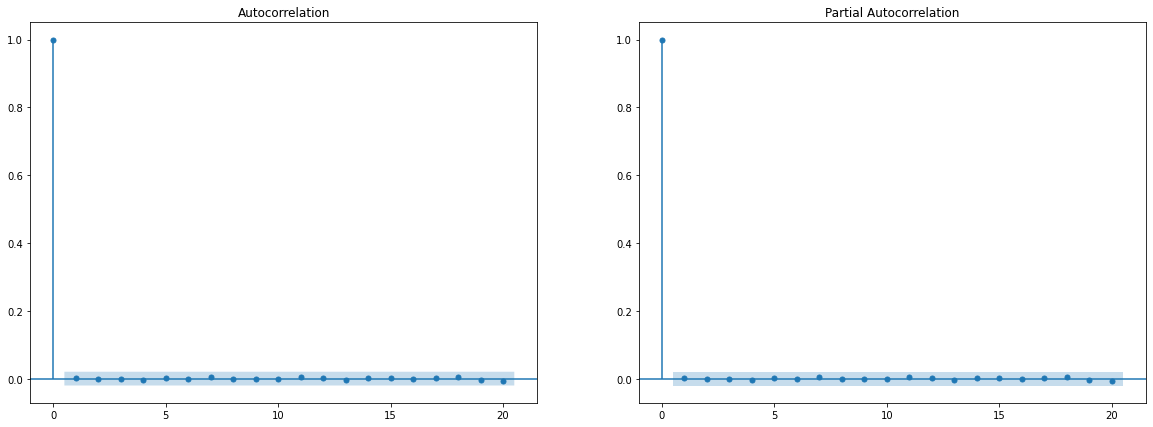

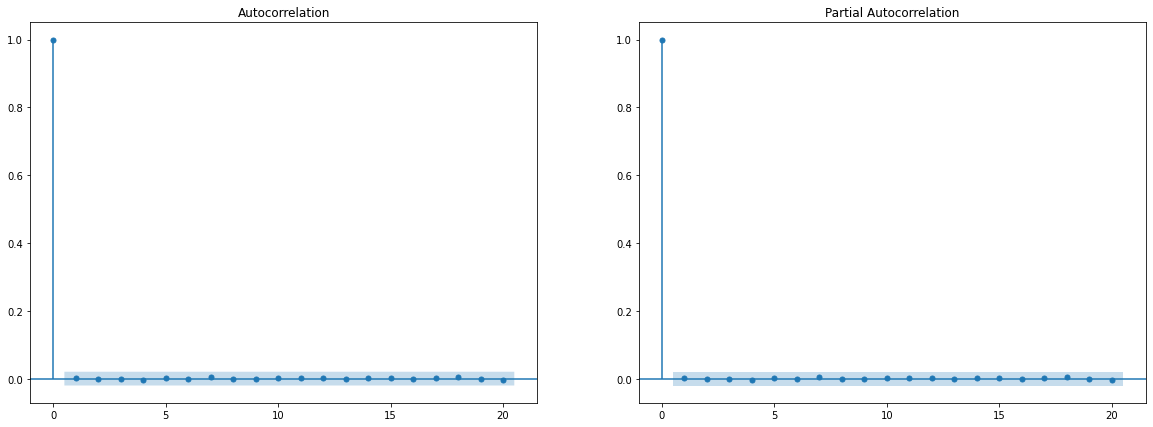

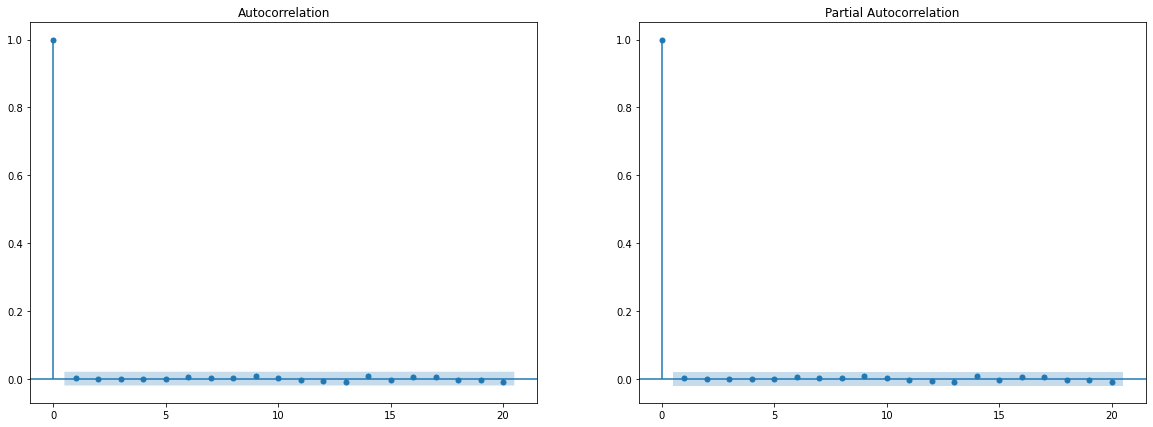

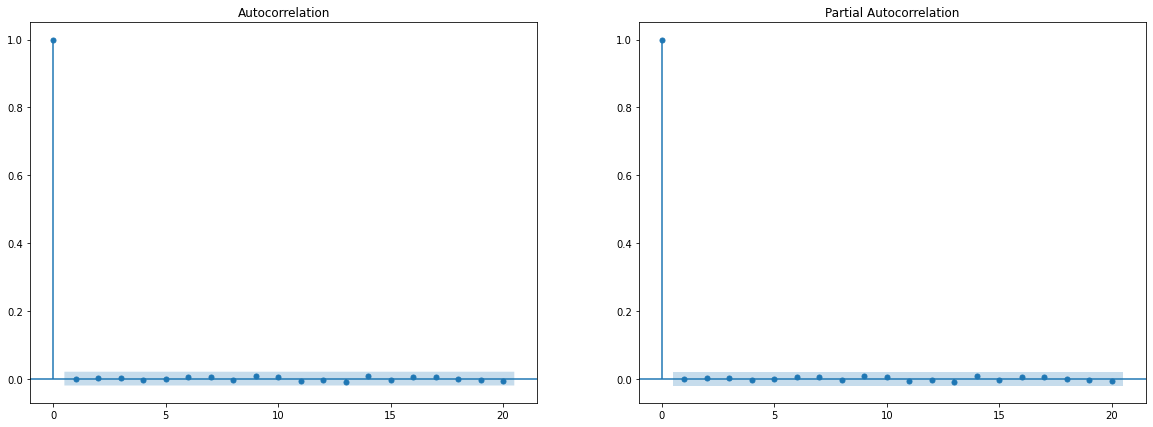

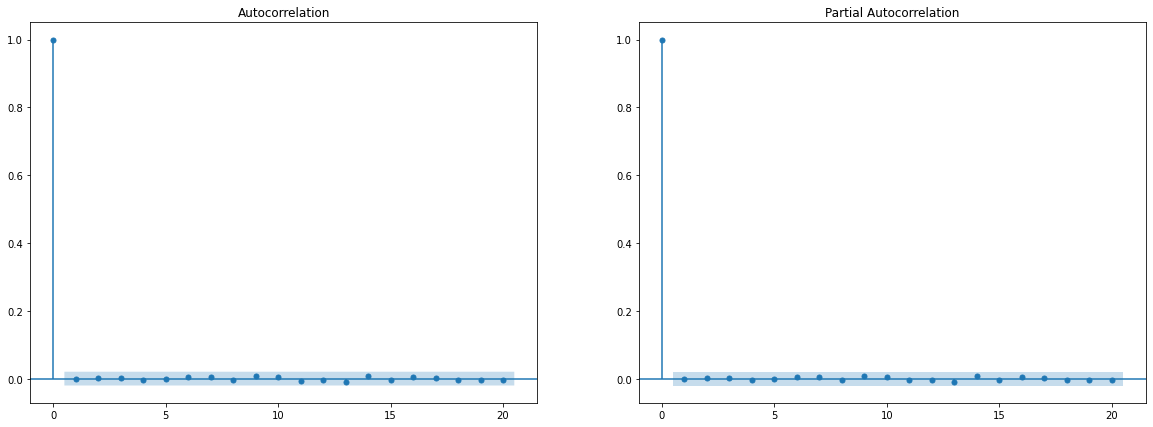

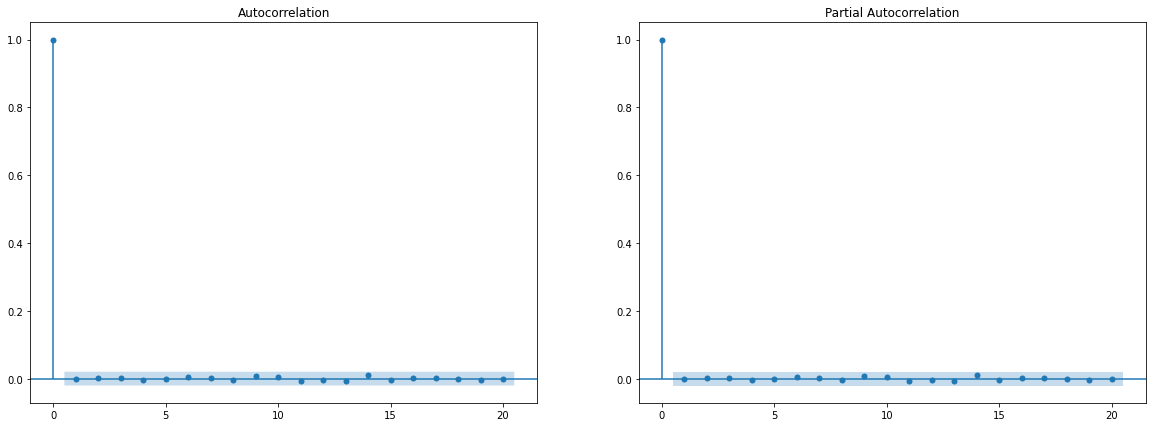

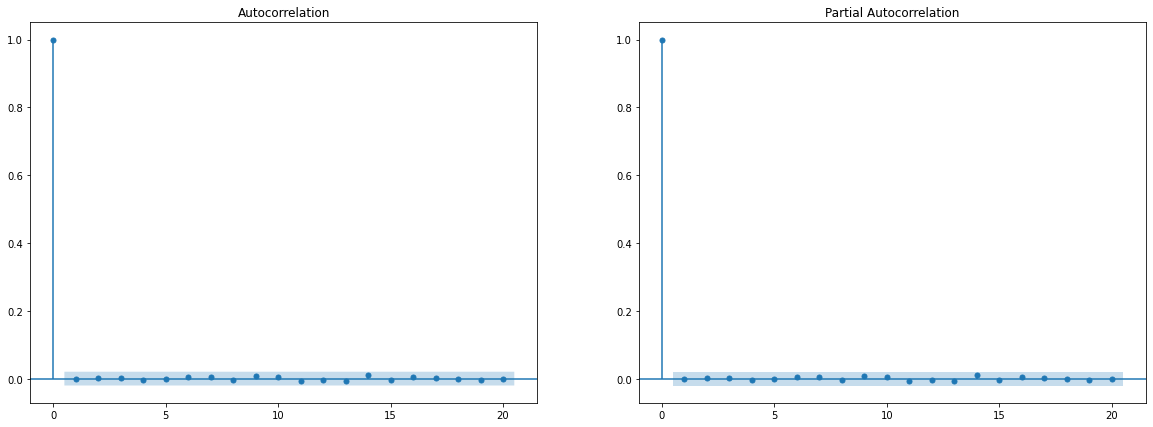

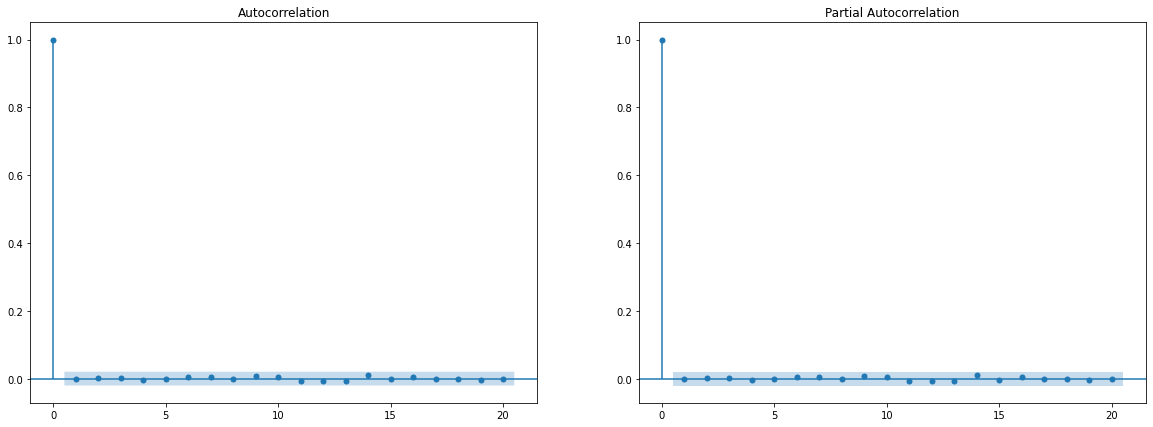

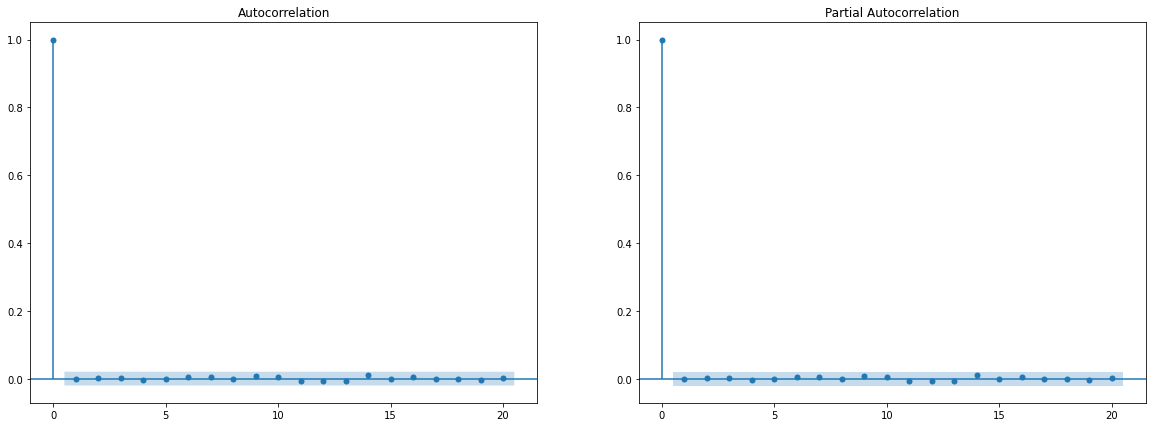

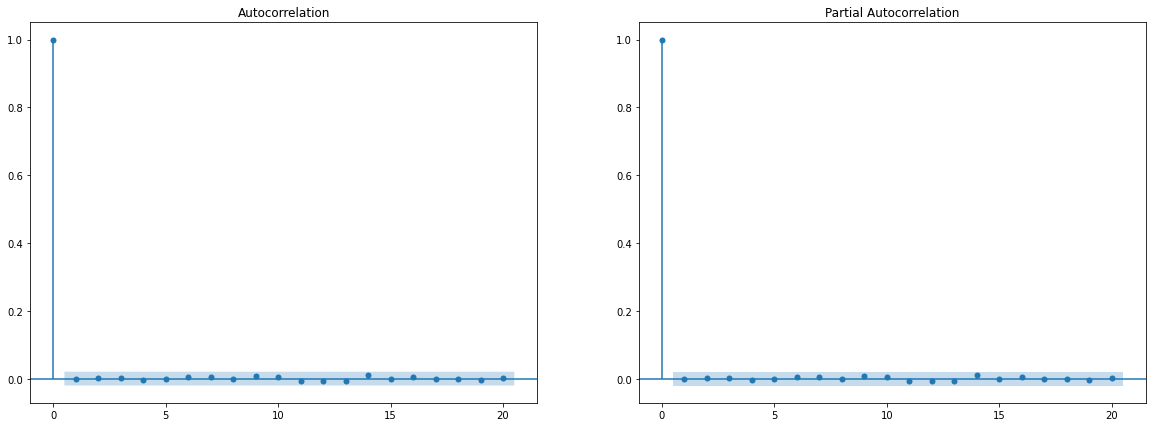

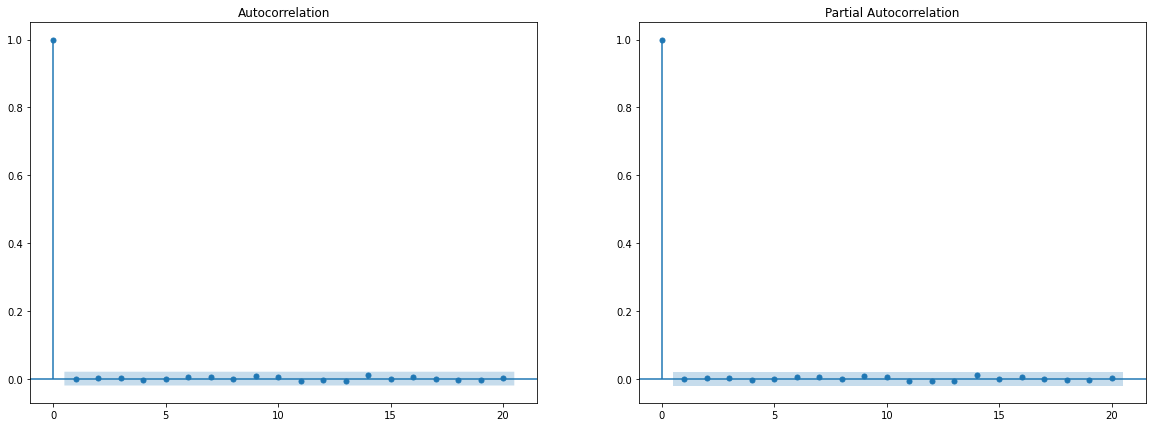

In [130]:
for i in residuals.columns:
    r=residuals[i]
    plt.rcParams["figure.figsize"] = (20,7)
    fig,ax = plt.subplots(1,2)
    sm.graphics.tsa.plot_acf(r,lags=20,ax=ax[0])
    sm.graphics.tsa.plot_pacf(r,lags=20,ax=ax[1])
    plt.show()

## The Durbin-Watson statistic will always have a value between 0 and 4. A value of 2.0 means that there is no auto-correlation detected in the sample. Values from 0 to less than 2 indicate positive auto-correlation and values from 2 to 4 indicate negative auto-correlation. A rule of thumb is that test statistic values in the range of 1.5 to 2.5 are relatively normal. Any value outside this range could be a cause for concern.

In [110]:
from statsmodels.stats.stattools import durbin_watson
out=durbin_watson(res.resid)

for col,val in zip(X_diff.columns,out):
    print((col),":",round(val,2))

1M : 2.0
2M : 2.0
3M : 2.0
6M : 2.0
9M : 2.0
1Y : 2.0
2Y : 2.0
3Y : 2.0
4Y : 2.0
5Y : 2.0
6Y : 2.0
7Y : 2.0
8Y : 2.0
9Y : 2.0
10Y : 2.0


## Box-Ljung Test (Whiteness Test)

- Null Hypothesis: Discrete white noise is a good fit to residuals
- Alternate Hypothesis: Residuals are not white

In [174]:
for i in residuals.columns:
    val=sm.stats.acorr_ljungbox(residuals[i], lags=[19], return_df=True).values
    p=val[0][1]
    print(p)
    if p > 0.05:
        print("For {} Discrete white noise is a good fit to residuals".format(i))
    else:
        print("For {} Discrete white noise is not a good fit to residuals".format(i))

0.9995920461411762
For 1M Discrete white noise is a good fit to residuals
0.9993391056229306
For 2M Discrete white noise is a good fit to residuals
0.9983567643666058
For 3M Discrete white noise is a good fit to residuals
0.99999963133279
For 6M Discrete white noise is a good fit to residuals
0.9999999847145798
For 9M Discrete white noise is a good fit to residuals
0.9999999995548545
For 1Y Discrete white noise is a good fit to residuals
0.9998459047322906
For 2Y Discrete white noise is a good fit to residuals
0.9997733370922434
For 3Y Discrete white noise is a good fit to residuals
0.9998707966592385
For 4Y Discrete white noise is a good fit to residuals
0.9998677198582556
For 5Y Discrete white noise is a good fit to residuals
0.999875870059243
For 6Y Discrete white noise is a good fit to residuals
0.9998788599434099
For 7Y Discrete white noise is a good fit to residuals
0.9998475919571137
For 8Y Discrete white noise is a good fit to residuals
0.9998208431456509
For 9Y Discrete white 

### Since the residuals are white we can proceed with the forecasting.

In [166]:
# Get the lag order
lag_order = res.k_ar
# Input data for forecasting which is 30 days data input
input_data = X_diff.values[-lag_order:]
print(input_data.shape)

(30, 15)


### Forecasting for 19 steps

In [156]:
# forecasting
pred = res.forecast(y=input_data, steps=19)
pred = pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred')
#print(pred)

In [157]:
# inverting transformation
def invert_transformation(X_train, pred):
    forecast = pred.copy()
    columns = X_train.columns
    for col in columns:
        forecast[str(col)+'_pred'] = X_train[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
    return forecast
output = invert_transformation(X_train, pred)

## MAPE for different steps ahead
- It is observed that the value of MAPE increases with increasing steps for all the time series.

In [158]:
for i,j in zip(output.columns,X_test.columns):
    combine = pd.concat([output[i], X_test[j]], axis=1)
    combine['MAPE'] = combine.apply(lambda row: abs(row[i]-row[j])/row[j] *100, axis = 1)
    combine['MAPE'] = pd.Series(["{0:.2f}%".format(val) for val in combine['MAPE']],index = combine.index)
    #combine = combine.reset_index()
    print(combine)
    #combine = comb

             1M_pred        1M   MAPE
2021-02-10  0.004134  0.004175  0.99%
2021-02-11  0.004164  0.004175  0.26%
2021-02-12  0.004193  0.004175  0.42%
2021-02-13  0.004169  0.004175  0.13%
2021-02-14  0.004171  0.004175  0.10%
2021-02-15  0.004106  0.004175  1.65%
2021-02-16  0.004156  0.004175  0.45%
2021-02-17  0.004139  0.004175  0.86%
2021-02-18  0.004136  0.004175  0.94%
2021-02-19  0.004148  0.004175  0.64%
2021-02-20  0.004161  0.004175  0.34%
2021-02-21  0.004176  0.004175  0.01%
2021-02-22  0.004107  0.004175  1.63%
2021-02-23  0.004112  0.004175  1.51%
2021-02-24  0.004079  0.004175  2.30%
2021-02-25  0.004057  0.004200  3.40%
2021-02-26  0.004070  0.004200  3.08%
2021-02-27  0.004051  0.004200  3.54%
2021-02-28  0.004051  0.004200  3.56%
             2M_pred        2M   MAPE
2021-02-10  0.004233  0.004275  0.98%
2021-02-11  0.004269  0.004275  0.15%
2021-02-12  0.004280  0.004275  0.12%
2021-02-13  0.004265  0.004275  0.24%
2021-02-14  0.004266  0.004275  0.21%
2021-02-15  

## Error values for different series forecast

In [159]:
for k,j in zip(output.columns,X_test.columns):
    combine = pd.concat([output[k], X_test[j]], axis=1)
    combine['MAPE'] = combine.apply(lambda row: row[k] /row[j] *100, axis = 1)
    combine['MAPE'] = pd.Series(["{0:.2f}%".format(val) for val in combine['MAPE']],index = combine.index)
    #combine = combine.reset_index()
    print(k,j)
    forecast_errors = [combine[j][i]- combine[k][i] for i in range(len(combine[j]))]
    bias = sum(forecast_errors) * 1.0/len(combine[j])
    print('Bias: %f' % bias)
    #print('R2 score:', r2_score(combine[j].values, combine[k].values))
    print('Mean absolute error:', mean_absolute_error(combine[j].values, combine[k].values))
    print('Mean squared error:', mean_squared_error(combine[j].values, combine[k].values))
    print('Root mean squared error:', np.sqrt(mean_squared_error(combine[j].values, combine[k].values)))
    #print(combine)

1M_pred 1M
Bias: 0.000055
Mean absolute error: 5.6929953930543217e-05
Mean squared error: 5.81392030024919e-09
Root mean squared error: 7.624906753691608e-05
2M_pred 2M
Bias: 0.000052
Mean absolute error: 5.2516983662936956e-05
Mean squared error: 4.271160391265717e-09
Root mean squared error: 6.535411533534608e-05
3M_pred 3M
Bias: 0.000055
Mean absolute error: 5.490865502048023e-05
Mean squared error: 4.378520181523197e-09
Root mean squared error: 6.61703874971516e-05
6M_pred 6M
Bias: 0.000083
Mean absolute error: 8.342711014028624e-05
Mean squared error: 8.55542554780052e-09
Root mean squared error: 9.249554339426586e-05
9M_pred 9M
Bias: 0.000092
Mean absolute error: 9.178814202345769e-05
Mean squared error: 1.0287740621672621e-08
Root mean squared error: 0.00010142850004644958
1Y_pred 1Y
Bias: 0.000282
Mean absolute error: 0.000281575450950588
Mean squared error: 1.2685650223491533e-07
Root mean squared error: 0.00035616920450105637
2Y_pred 2Y
Bias: 0.000506
Mean absolute error: 0.0

## Mean Absolute Error with increasing time steps


In [167]:
mae=[]
for i in range(19):
    mae.append(mean_absolute_error(output.iloc[i],X_test.iloc[i]))  
ser = go.Scatter(x=np.arange(1,19+1),
                         y=mae)
layout = go.Layout(title='Mean Absolute Error with increasing steps', xaxis=dict(title='Steps'),
                   yaxis=dict(title='MAE'))

fig = go.Figure(data=[ser], layout=layout)
py.iplot(fig, sharing='public')

## Mean Squared Error with increasing maturity

In [168]:
mae_maturity=[]
for i in range(15):
    mae_maturity.append(mean_absolute_error(output.iloc[:,i:i+1],X_test.iloc[:,i:i+1])) 
ser = go.Scatter(x=output.columns,
                         y=mae)
layout = go.Layout(title='Mean Absolute Error with increasing maturity', xaxis=dict(title='Maturity'),
                   yaxis=dict(title='MAE'))

fig = go.Figure(data=[ser], layout=layout)
py.iplot(fig, sharing='public')

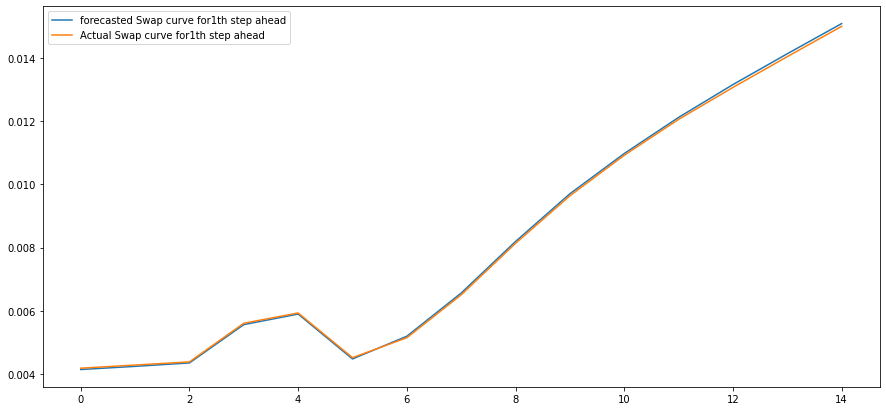

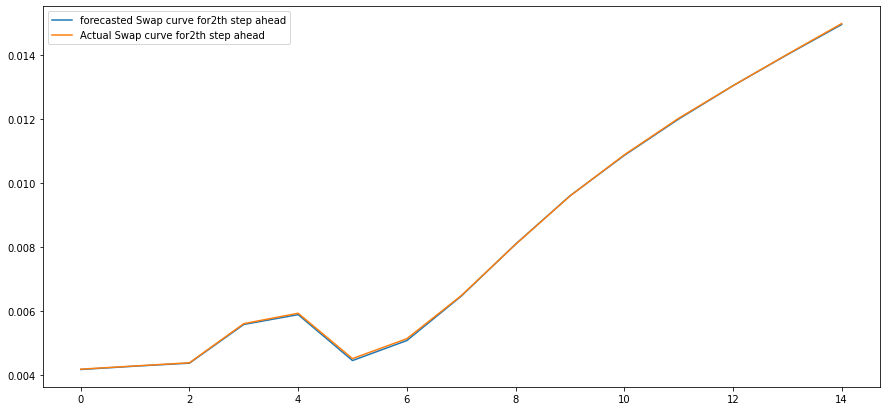

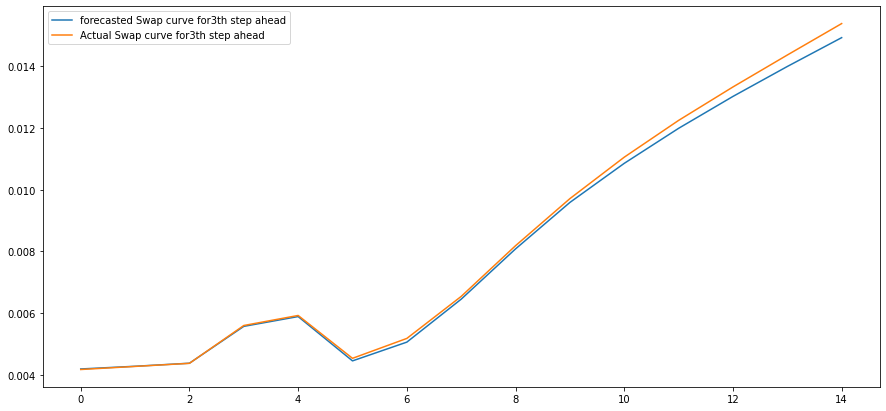

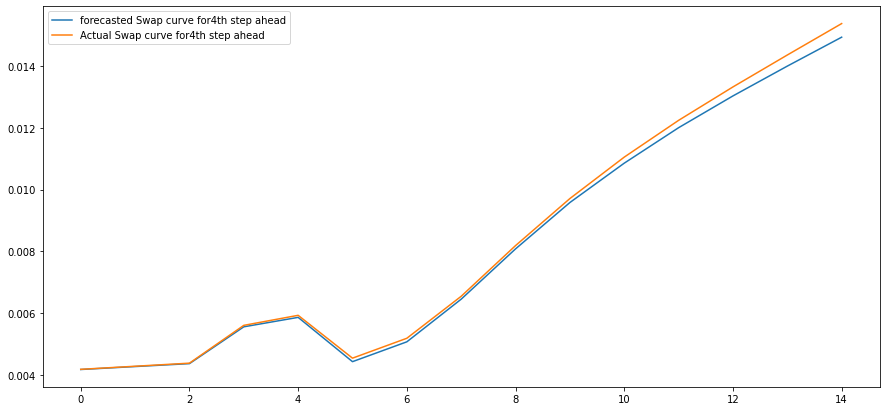

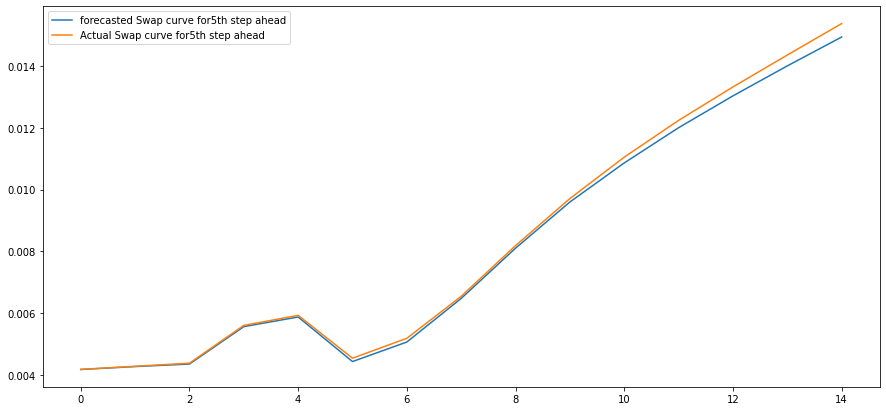

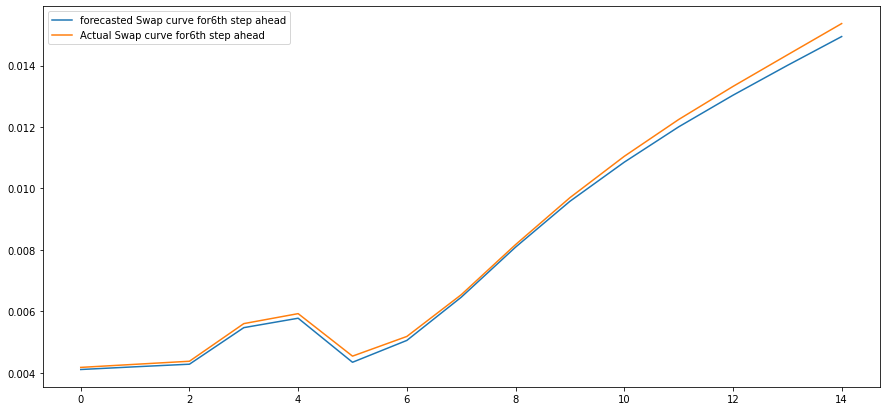

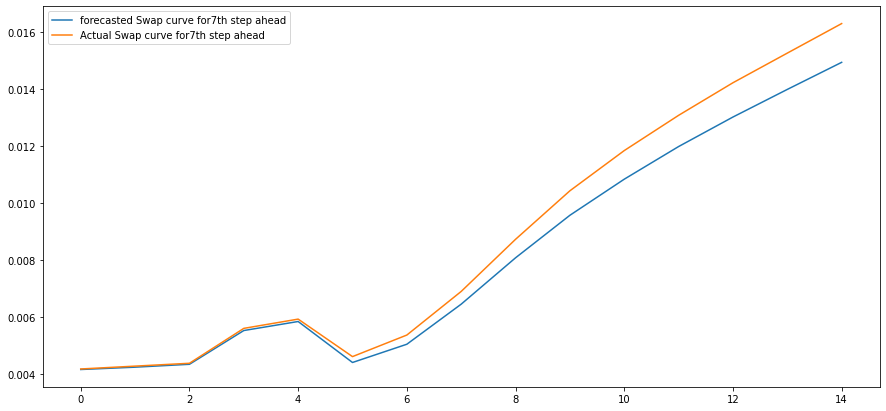

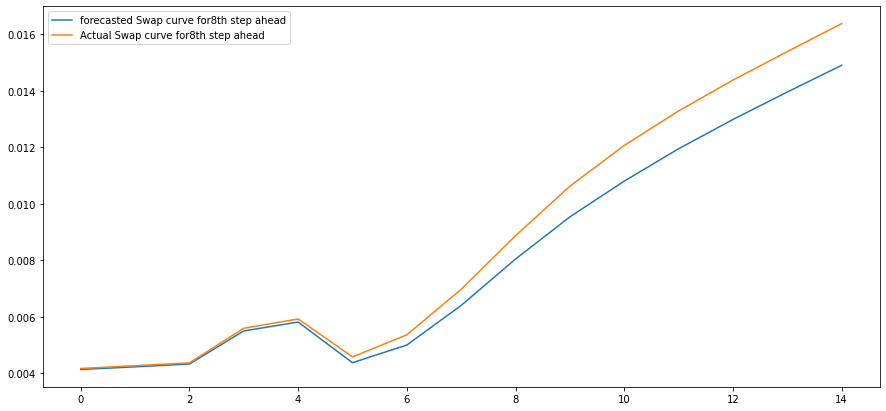

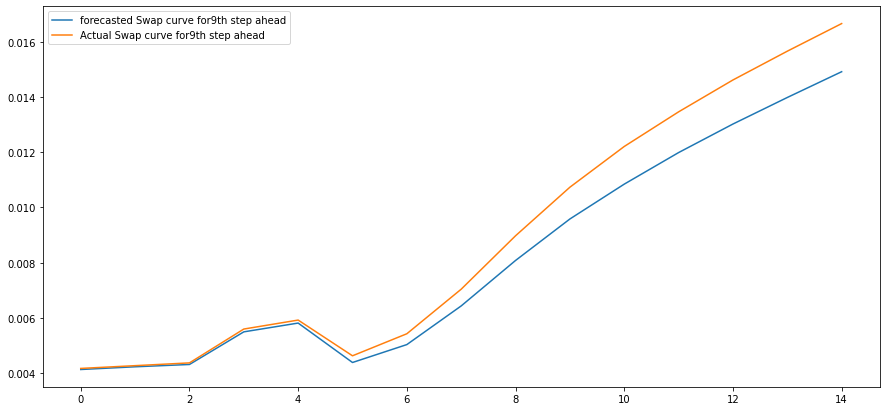

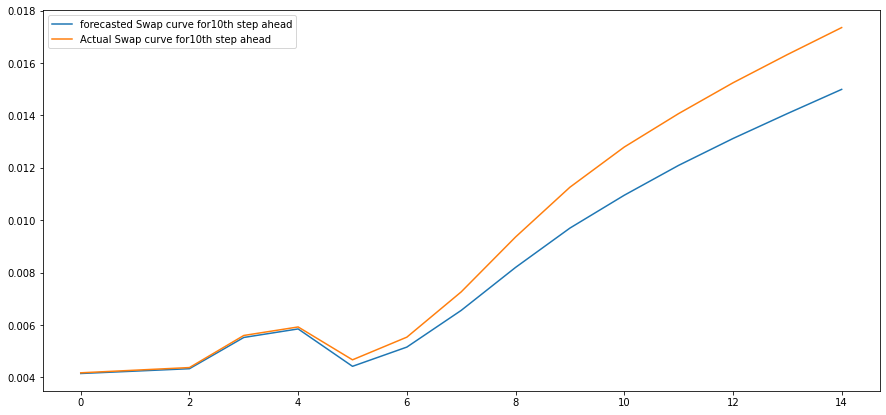

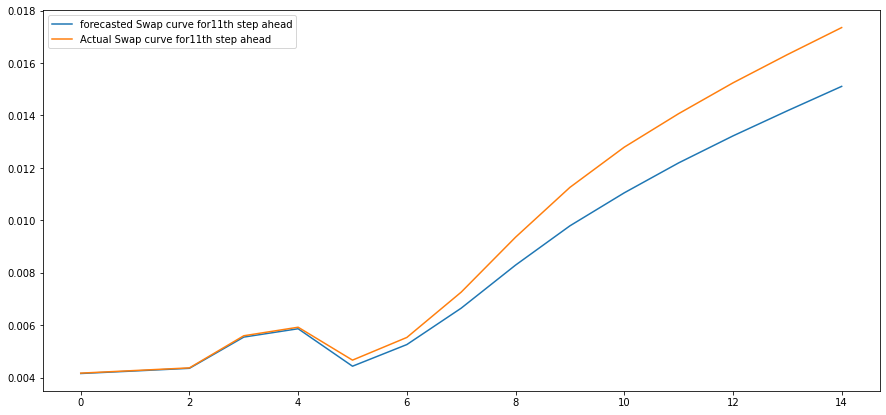

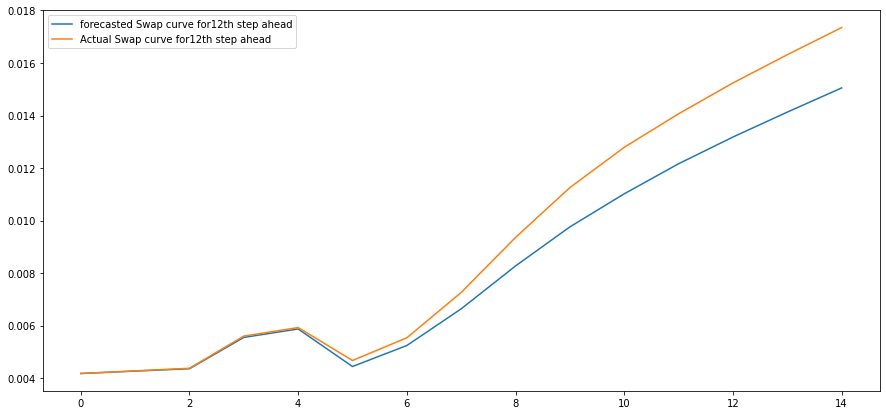

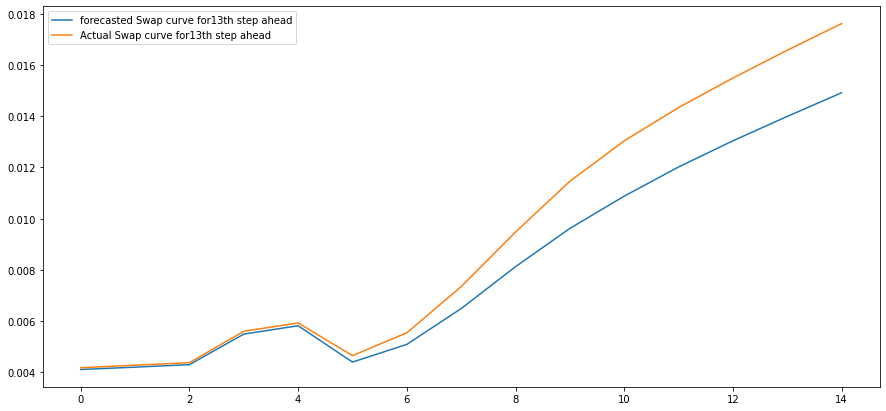

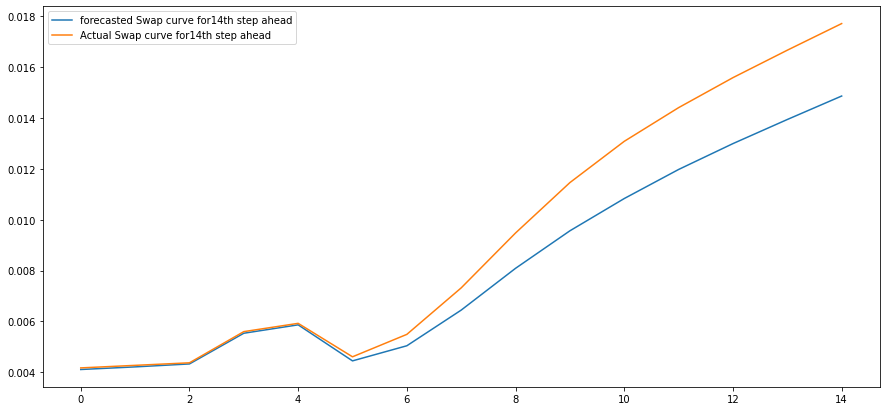

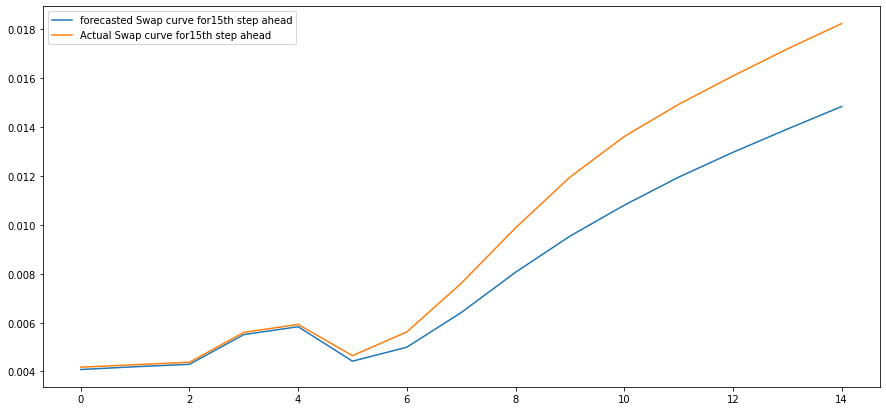

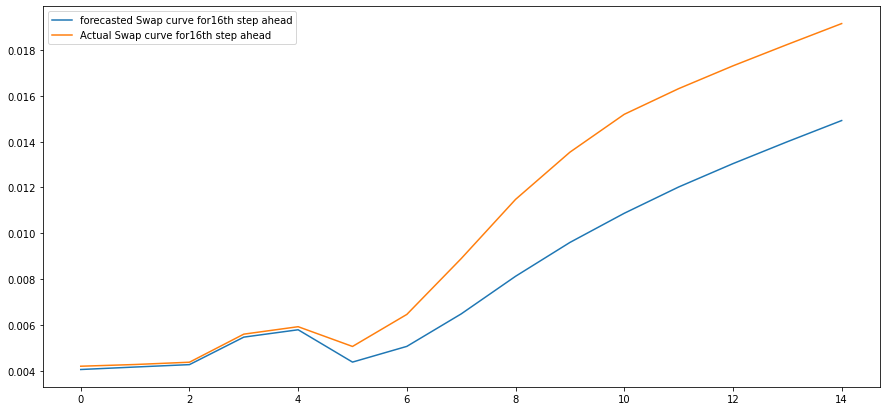

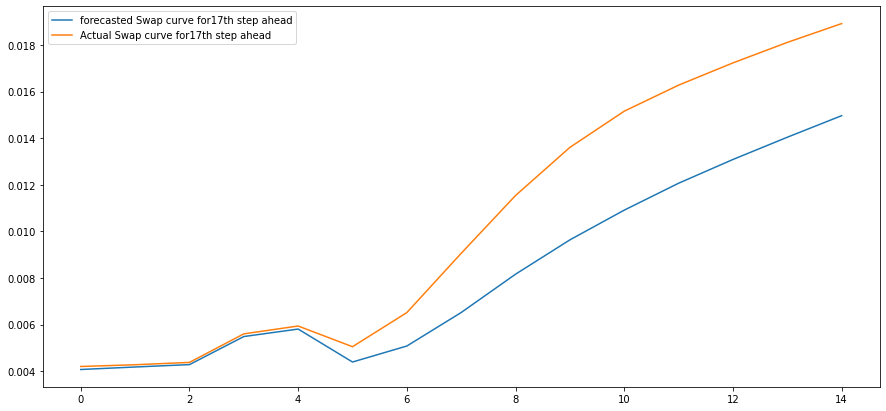

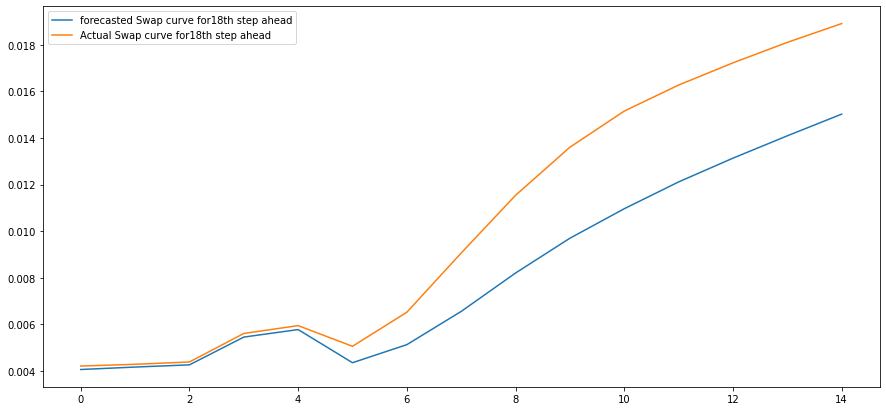

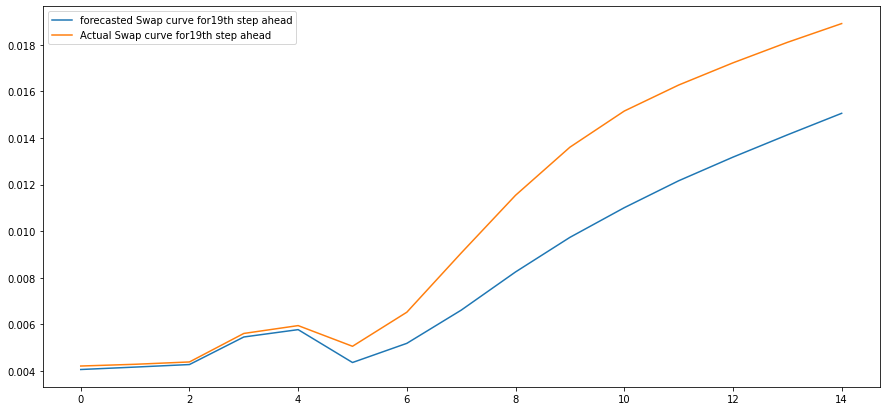

In [162]:
for i in range(19):
    plt.plot(output.iloc[i:i+1,].values[0],label="forecasted Swap curve for"+ str(i+1)+"th step ahead" )
    plt.plot(X_test.iloc[i:i+1,].values[0],label="Actual Swap curve for"+ str(i+1)+"th step ahead")
    plt.legend()
    plt.show()

## Forecasting the final Swap Curve for 19th March 2021 using the entire data.

In [163]:
train=df.diff().dropna()
mod = VAR(train)
res = mod.fit(maxlags=30, ic='aic')
print(res.summary())
y_fitted = res.fittedvalues

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 05, Aug, 2021
Time:                     10:29:45
--------------------------------------------------------------------
No. of Equations:         15.0000    BIC:                   -280.064
Nobs:                     9331.00    HQIC:                  -283.483
Log likelihood:       1.13896e+06    FPE:               1.32318e-124
AIC:                     -285.242    Det(Omega_mle):    6.51817e-125
--------------------------------------------------------------------
Results for equation 1M
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const          -0.000003         0.000002           -1.355           0.176
L1.1M          -0.067797         0.028174           -2.406           0.016
L1.2M           0.007270         0.048332            0.150           0.880
L1.3M       

In [141]:
# Get the lag order
lag_order = res.k_ar
# Input data for forecasting
input_data = train.values[-lag_order:]
pred = res.forecast(y=input_data, steps=19)
pred = pd.DataFrame(pred, index=pd.date_range(start="2021-03-01",end="2021-03-19"), columns=X_test.columns + '_pred')

In [142]:
output = invert_transformation(df, pred)

In [143]:
series_1m= df["1M"]
ser = go.Scatter(x=output.columns,
                         y=output[-1:].values[0])
layout = go.Layout(title='Forecast for 19th March', xaxis=dict(title='Maturities'),
                   yaxis=dict(title='(swap rates)'))

fig = go.Figure(data=[ser], layout=layout)
py.iplot(fig, sharing='public')

In [144]:
output[-1:]

1M_pred   2M_pred   3M_pred   6M_pred   9M_pred   1Y_pred  \
2021-03-19  0.004133  0.004302  0.004501  0.005605  0.005928  0.005003   

             2Y_pred   3Y_pred  4Y_pred   5Y_pred   6Y_pred   7Y_pred  \
2021-03-19  0.006767  0.009572  0.01216  0.014201  0.015817  0.017042   

             8Y_pred   9Y_pred  10Y_pred  
2021-03-19  0.018039  0.018944  0.019793